In [4]:
# Enable the automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Define the R script to read the RDS file
read_rds = ro.r('readRDS')

# Call the R function `readRDS` from Python
r_data = read_rds('reddit.RDS')

# Convert the R data structure to a pandas DataFrame
df = pandas2ri.py2rpy(r_data)

df = pd.DataFrame(df)
df = df.T

column_names = ['tag', 'title', 'author', 'comments', 'id', 'num_comments',
       'permalink', 'score', 'upvote_ratio', 'url', 'created_utc',
       'comments_feed']
df.columns = column_names

meta_df = df.copy()


In [5]:
meta_df[:1]

tag                                              title  author  \
0  beltline  Beltline's Eastside Trail transit plan meets o...  cox_ph   

                                            comments       id num_comments  \
0  <praw.models.comment_forest.CommentForest obje...  12l1rb1          248   

                                           permalink score upvote_ratio  \
0  /r/Atlanta/comments/12l1rb1/beltlines_eastside...   162         0.96   

                                                 url   created_utc  \
0  https://www.axios.com/local/atlanta/2023/04/13...  1681416024.0   

                                       comments_feed  
0  [[Redditor(name='Thrasher678'), "Just tell me ...

In [6]:
# Read meta_comments_df.csv
meta_comments_df = pd.read_csv('metav2_comments_df.csv', index_col=0)

In [11]:
meta_comments_df[:2]

comment_id parent_id                                               body  \
0    jg5b9y4       NaN  Just tell me I will be able to ride it from PC...   
1    jg51z7v       NaN  Streetcar was approved as the LPA by the Marta...   

        author                 time  score subreddit_id thread_id  year  \
0  Thrasher678  2023-04-13 17:20:20    161     t5_2qiq9   12l1rb1  2023   
1          NaN  2023-04-13 16:20:23    143     t5_2qiq9   12l1rb1  2023   

  subreddit_name  sentiment  bert_sentiment  
0        Atlanta     0.0000        0.998572  
1        Atlanta     0.4215        0.760574

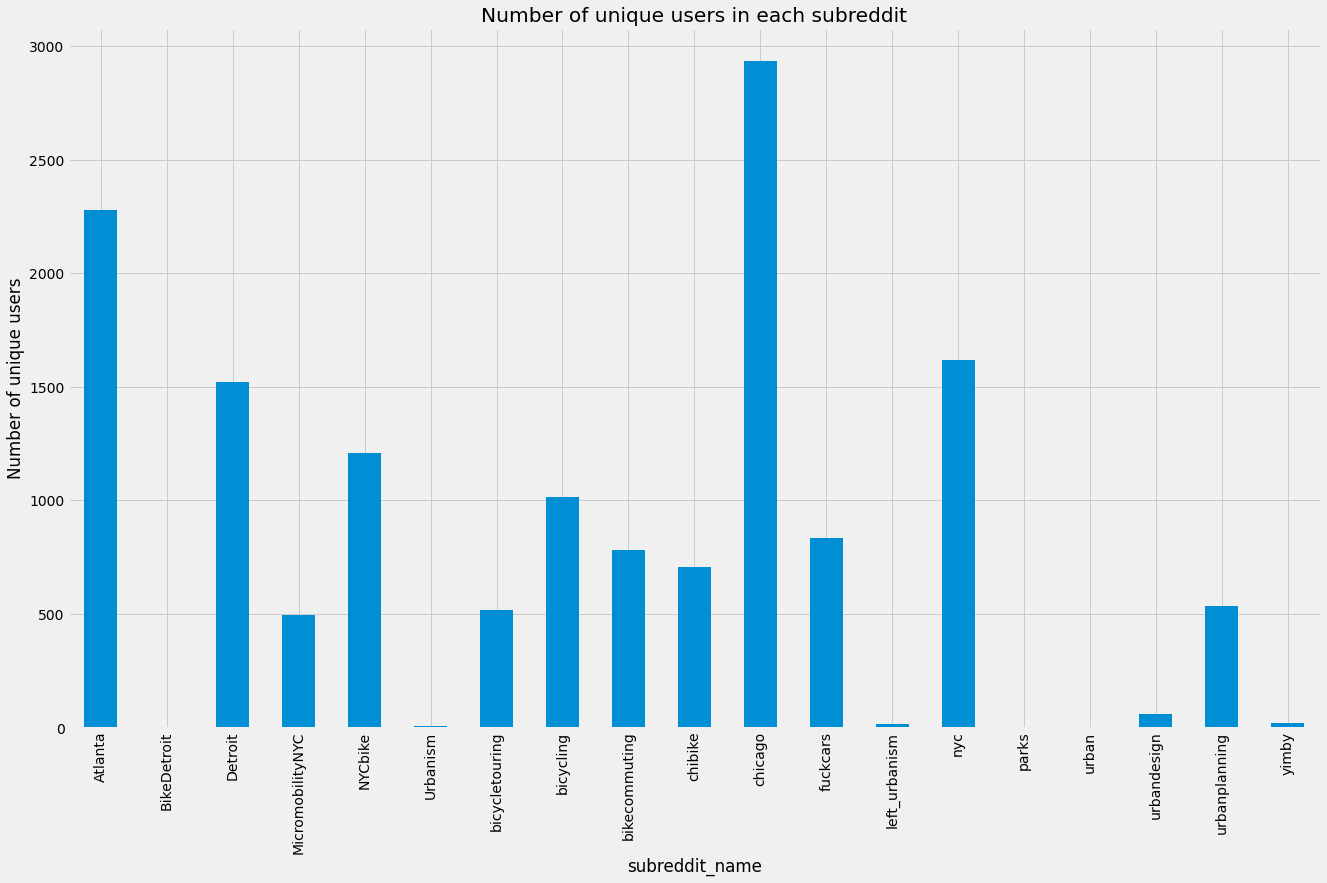

In [619]:
# plot the number of unique users in each subreddit
meta_comments_df.groupby('subreddit_name')['author'].nunique().plot(kind='bar', figsize=(20, 12))
plt.ylabel('Number of unique users')
plt.title('Number of unique users in each subreddit')
#change colormap to fivetirtyeight
plt.style.use('fivethirtyeight')

plt.show()


In [460]:
# using meta_comments_df, plot number of unqiue users in each subreddit
#meta_comments_df.groupby('subreddit_name')['author'].nunique().plot(kind='bar', figsize=(20,10), title='Number of unique users in each subreddit')

# use plotly to plot number of unqiue users in each subreddit
import plotly.express as px
fig = px.bar(meta_comments_df.groupby('subreddit_name')['author'].nunique(), title='User engaging with "rails-to-trails" on Subreddits')

fig.update_layout(yaxis_title='Number of unique users')
fig.show()

# export plotly figure as html
fig.write_html("user_engagement_subreddit.html")

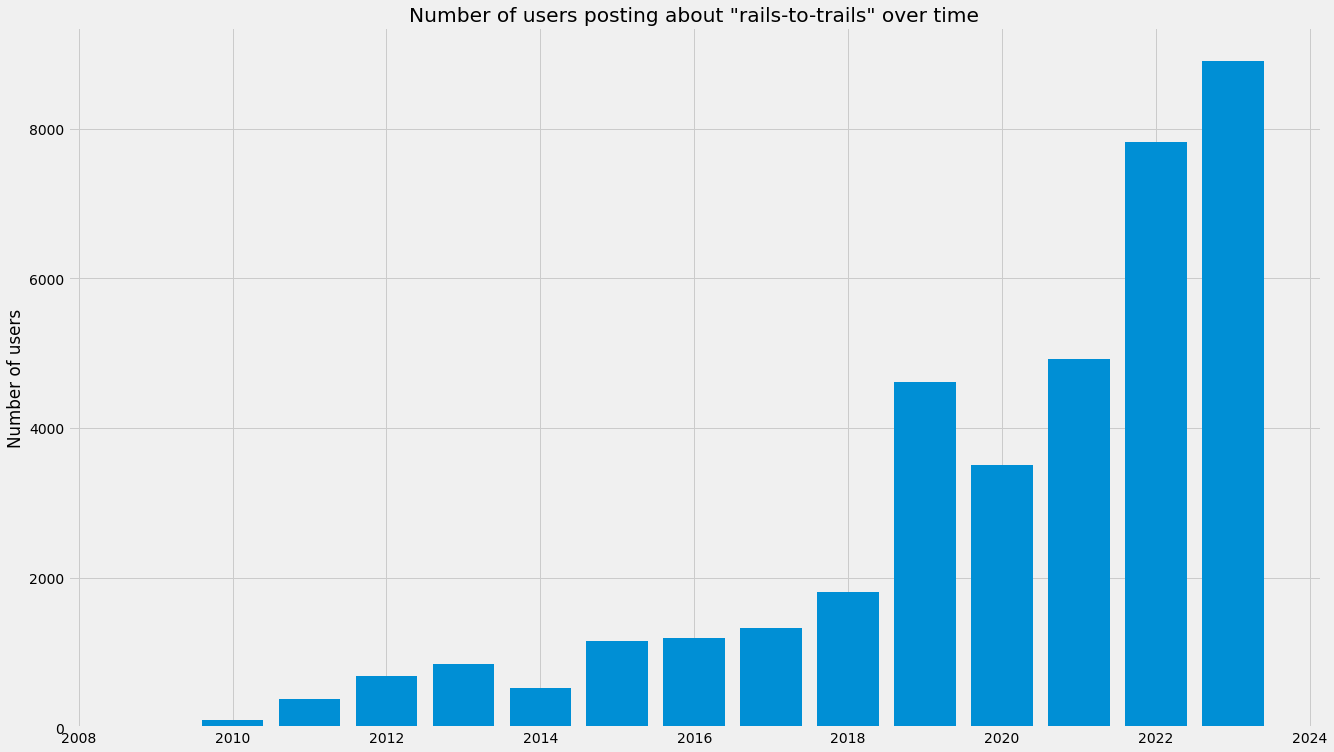

In [621]:
counts = meta_comments_df['year'].value_counts().sort_index()

plt.figure(figsize=(20,12))
plt.bar(counts.index, counts.values)

plt.ylabel('Number of users')
plt.title('Number of users posting about "rails-to-trails" over time')
#change colormap to fivetirtyeight
plt.style.use('fivethirtyeight')

plt.show()

In [468]:
import plotly.graph_objects as go

# Count the number of comments & posts per year
counts = meta_comments_df['year'].value_counts().sort_index()

# Create a bar chart
fig = go.Figure(data=go.Bar(x=counts.index, y=counts.values, marker_color='green'))

# Set layout properties
fig.update_layout(
    title='Number of Comments & Posts per Year',
    xaxis_title='Year',
    yaxis_title='Number of Comments & Posts',
    plot_bgcolor='lightgrey',
    autosize=False,
    width=1000,
    height=500,
)

# Show the plot
fig.show()

In [13]:
# get sentiment of each comment from BERT
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

c:\Users\Mohsin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [14]:
# Classify a sentence
sentence = "I am not sure about programming but i am thinking!"

from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bertSentiment(sentence):
    # Tokenize the text, ensuring that the sequence length is no more than 512
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:min(len(tokens), 500)]  # Truncate if necessary

    # Convert tokens to string
    text = tokenizer.convert_tokens_to_string(tokens)

    result = classifier(text)
    sentiment_score = result[0]['score'] if result[0]['label'] == 'POSITIVE' else  1 - result[0]['score']
    return sentiment_score

In [15]:
# calculate sentiment of comments by user using VADER
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sid.polarity_scores(text)["compound"]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Creating dataframe about User Activity

In [16]:
comments_count_by_user = {}

for idx, row in meta_comments_df.iterrows():
    user = row['author']
    text = row['body']
    comment_time = row['time']
    # convert time to unix timestamp
    comment_time = time.mktime(time.strptime(comment_time, "%Y-%m-%d %H:%M:%S"))
    upvotes = row['score']
    thread_id = row['thread_id']
    # get the setiment of the comment
    sentiment = get_sentiment(text)

    if user is not None:
        if user not in comments_count_by_user:
            # adding the count of comments by user
            comments_count_by_user[user] = {"user": user,
                                            "comments_count": 1,
                                            "last_comment": comment_time,
                                            "first_comment": comment_time,
                                            "tot_sentiment": sentiment,
                                            "upvotes": upvotes,
                                            "thread_id": [thread_id]}
        else:
            comments_count_by_user[user]["comments_count"] += 1
            comments_count_by_user[user]["tot_sentiment"] += sentiment
            comments_count_by_user[user]["upvotes"] += upvotes
            if thread_id not in comments_count_by_user[user]["thread_id"]:
                comments_count_by_user[user]["thread_id"].append(thread_id)

            if comment_time > comments_count_by_user[user]["last_comment"]:
                comments_count_by_user[user]["last_comment"] = comment_time
            if comment_time < comments_count_by_user[user]["first_comment"]:    
                comments_count_by_user[user]["first_comment"] = comment_time


# counting the authors of OP in the comments feed
for index, entry in meta_df.iterrows():
    user = entry["author"]
    comment_time = entry["created_utc"]
    text = entry["title"]
    sentiment = get_sentiment(text)
    upvotes = entry["score"]
    thread_id = entry["id"]

    if user not in comments_count_by_user:
        comments_count_by_user[user] = {"user": user,
                                        "comments_count": 1,
                                        "last_comment": comment_time,
                                        "first_comment": comment_time,
                                        "tot_sentiment": sentiment,
                                        "upvotes": upvotes,
                                        "thread_id": [thread_id]}
    else:
        comments_count_by_user[user]["comments_count"] += 1
        comments_count_by_user[user]["tot_sentiment"] += sentiment
        comments_count_by_user[user]["upvotes"] += upvotes
        if thread_id not in comments_count_by_user[user]["thread_id"]:
            comments_count_by_user[user]["thread_id"].append(thread_id)

        if comment_time > comments_count_by_user[user]["last_comment"]:
            comments_count_by_user[user]["last_comment"] = comment_time
        if comment_time < comments_count_by_user[user]["first_comment"]:    
            comments_count_by_user[user]["first_comment"] = comment_time 

In [17]:
from datetime import datetime as dt

# convert utc to datetime
def convert_utc_to_datetime(utc):
    return dt.fromtimestamp(utc)

In [18]:
users_df = []
users_df = pd.DataFrame(comments_count_by_user).T

# convert utc to datetime in users_df
users_df["last_comment"] = users_df["last_comment"].apply(convert_utc_to_datetime)
users_df["first_comment"] = users_df["first_comment"].apply(convert_utc_to_datetime)

# calculate frequency of comments by user
users_df["frequency days/comment"] = (users_df["last_comment"] - users_df["first_comment"]).dt.days / users_df["comments_count"]

# round the frequency to whole numbers
users_df["frequency days/comment"] = users_df["frequency days/comment"].astype(int)

# getting the avg sentiment 
users_df["avg_sentiment"] = users_df["tot_sentiment"] / users_df["comments_count"]


fltrd_users_df = users_df[users_df["comments_count"] > 1]

fltrd_users_df["threads_active"] = fltrd_users_df["thread_id"].apply(lambda x: len(x))

fltrd_users_df["comments_count"] = pd.to_numeric(fltrd_users_df["comments_count"], errors='coerce')




C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2531471530.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2531471530.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
fltrd_users_df[(fltrd_users_df["avg_sentiment"] < -0) & (fltrd_users_df["comments_count"] > 30)]

user  comments_count        last_comment  \
ArchEast                        ArchEast             214 2023-09-12 09:31:40   
Antilon                          Antilon              31 2023-09-12 12:46:00   
dbclass                          dbclass              64 2023-05-13 18:33:17   
possibilistic              possibilistic              37 2022-09-14 21:02:01   
PhileasFoggsTrvlAgt  PhileasFoggsTrvlAgt              40 2023-08-09 15:47:11   
wpm                                  wpm              57 2023-07-24 20:03:45   
abuchewbacca1995        abuchewbacca1995              66 2023-10-06 14:40:59   
ColHaberdasher            ColHaberdasher              37 2019-02-08 21:31:00   
jhb42                              jhb42              45 2023-06-21 01:24:37   

                          first_comment tot_sentiment upvotes  \
ArchEast            2013-12-06 08:20:31        -0.213    2622   
Antilon             2019-06-04 12:23:29       -0.3766     304   
dbclass             2020-06-04 13:06:46       -0.6198    1495   
possibilistic       2019-04-19 16:07:34       -7.7106      79   
PhileasFoggsTrvlAgt 2019-09-09 11:17:20       -0.6742     507   
wpm                 2016-04-26 18:29:51       -8.9059     398   
abuchewbacca1995    2019-05-16 11:59:37       -2.5997     -28   
ColHaberdasher      2019-02-07 16:00:50      -10.2833      94   
jhb42               2023-06-09 22:09:02       -6.0877      57   

                                                             thread_id  \
ArchEast             [12l1rb1, 13enrrk, y90d3d, zh7q18, ummq0s, 10s...   
Antilon              [12l1rb1, 13enrrk, 15g8w4p, 1496bj3, 16g4d23, ...   
dbclass              [13enrrk, y90d3d, zh7q18, ummq0s, xe4hdo, 12bu...   
possibilistic        [xe4hdo, go1inq, vxb0ho, qwdny4, w7qtx7, ftwgi...   
PhileasFoggsTrvlAgt  [142su0m, d8ng48, j9zwqk, jv8bl5, e1i4yo, em1z...   
wpm                  [816bus, fp3dhm, 14ypomu, p2ekia, e1i4yo, 4lwr...   
abuchewbacca1995                    [16n5r1y, bpdlsd, fefedk, 171hc9p]   
ColHaberdasher                                                [ao5rmj]   
jhb42                                                        [1458pvy]   

                     frequency days/comment avg_sentiment  threads_active  
ArchEast                                 16     -0.000995              38  
Antilon                                  50     -0.012148               8  
dbclass                                  16     -0.009684              25  
possibilistic                            33     -0.208395              11  
PhileasFoggsTrvlAgt                      35     -0.016855              20  
wpm                                      46     -0.156244              33  
abuchewbacca1995                         24     -0.039389               4  
ColHaberdasher                            0     -0.277927               1  
jhb42                                     0     -0.135282               1

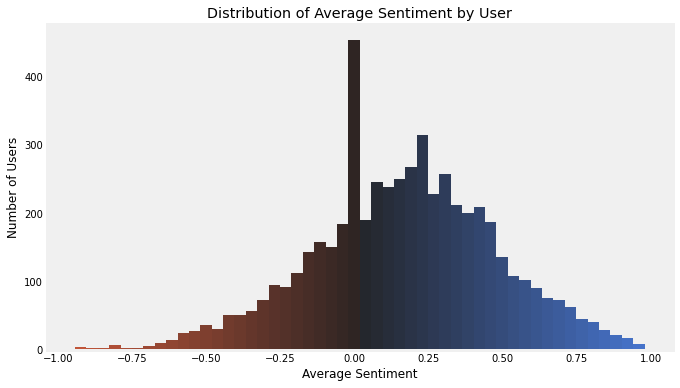

In [35]:
plt.style.use('fivethirtyeight')

# Create a diverging palette
palette = sns.diverging_palette(20, 256,center="dark", n=256)

# Create a function to map the colors
def map_colors(value):
    value_index = int((value - fltrd_users_df["avg_sentiment"].min()) / (fltrd_users_df["avg_sentiment"].max() - fltrd_users_df["avg_sentiment"].min()) * 255)
    return palette[value_index]

# Create the histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(fltrd_users_df["avg_sentiment"], bins=50)

# Color each bin
for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    x = np.mean([leftside, rightside])
    color = map_colors(x)
    patch.set_facecolor(color)

plt.xlabel("Average Sentiment")
plt.ylabel("Number of Users")
plt.title("Distribution of Average Sentiment by User")
plt.grid(False)
plt.show()

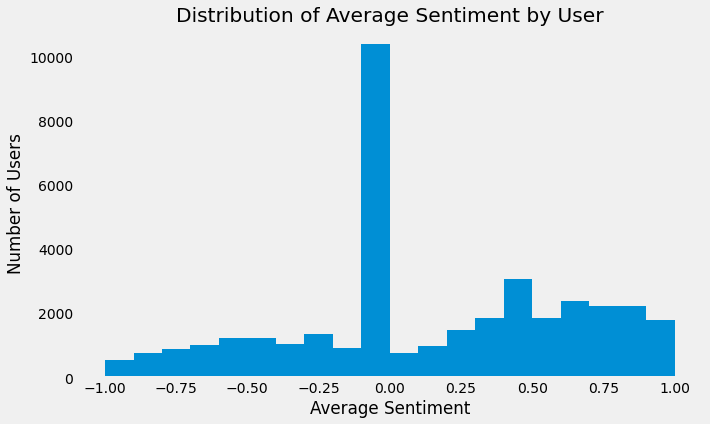

In [623]:
plt.style.use('fivethirtyeight')

# plot a distribution of the sentiment of comments
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(meta_comments_df["sentiment"], bins=20)
plt.xlabel("Average Sentiment")
plt.ylabel("Number of Users")
plt.title("Distribution of Average Sentiment by User")
plt.grid(False)
plt.show()

c:\Users\Mohsin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

c:\Users\Mohsin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

invalid value encountered in log10

c:\Users\Mohsin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



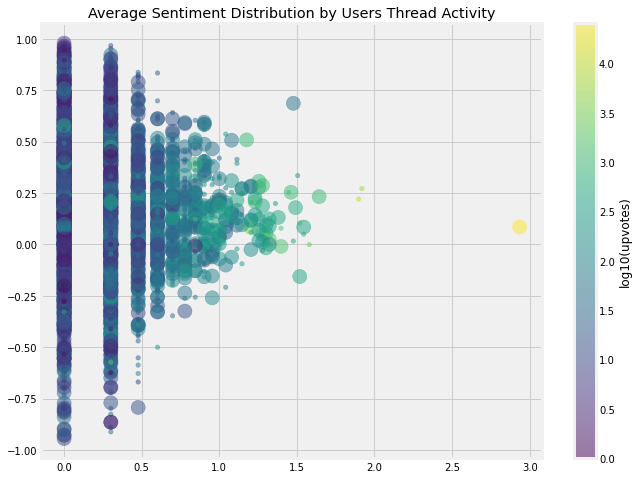

In [36]:
plt.figure(figsize=(10, 8))
#plt.plot(fltrd_users_df["avg_sentiment"],fltrd_users_df["comments_count"],alpha=0.5)

data = np.log10(fltrd_users_df["threads_active"])
colors = np.log10(fltrd_users_df["upvotes"].astype(int))

plt.scatter(data, fltrd_users_df["avg_sentiment"], alpha=0.5, s=colors, c=colors, cmap='viridis', sizes=(20, 200))

plt.title("Average Sentiment Distribution by Users Thread Activity")
plt.colorbar(label='log10(upvotes)')
plt.show()

In [20]:
fltrd_users_df[:3]

user  comments_count        last_comment  \
Thrasher678  Thrasher678               3 2023-04-13 17:20:20   
NaN                  NaN            4484 2023-10-31 12:17:55   
wambulancer  wambulancer               4 2023-08-22 11:42:11   

                  first_comment tot_sentiment upvotes  \
Thrasher678 2017-02-25 19:14:12        1.1361     131   
NaN         2009-12-18 12:26:25      380.6435   25609   
wambulancer 2023-04-13 16:16:36       -1.2466     472   

                                                     thread_id  \
Thrasher678                                  [12l1rb1, 5w59gx]   
NaN          [12l1rb1, 13enrrk, y90d3d, zh7q18, ummq0s, c0j...   
wambulancer                        [12l1rb1, 15y3vnm, 13p0k8o]   

             frequency days/comment avg_sentiment  threads_active  
Thrasher678                     745        0.3787               2  
NaN                               1      0.084889             862  
wambulancer                      32      -0.31165               3

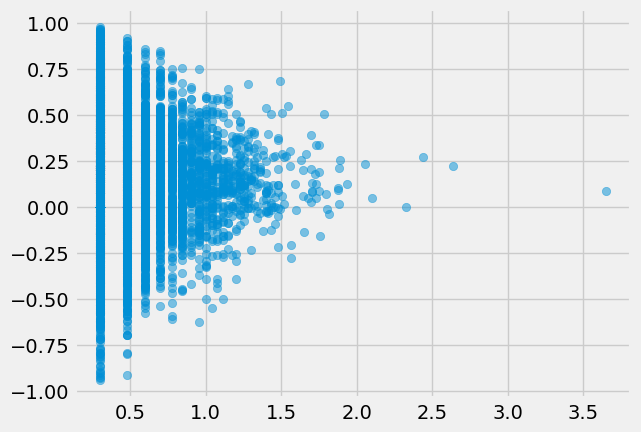

In [36]:
plt.scatter(np.log10(fltrd_users_df["comments_count"]), fltrd_users_df["avg_sentiment"], alpha=0.5)

So the more you engage, by either comment or posting, the more nuanced you get? 

c:\Users\Mohsin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

divide by zero encountered in log10

c:\Users\Mohsin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning:

invalid value encountered in log10



<Axes: xlabel='tot_sentiment', ylabel='Count'>

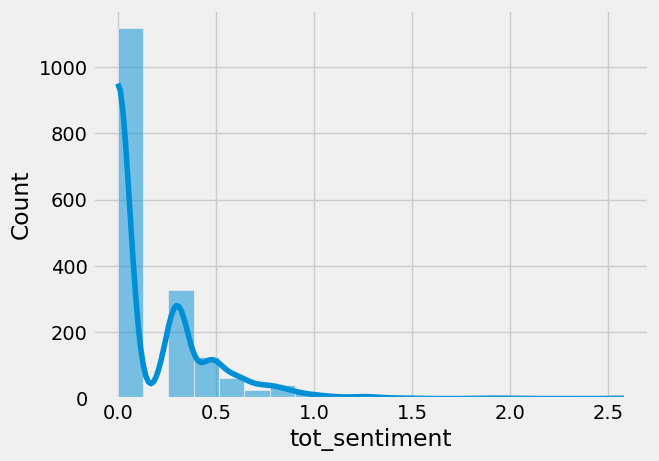

In [37]:
sns.histplot(np.log10(fltrd_users_df["tot_sentiment"].astype(int)), bins=20, kde=True)

In [21]:
meta_comments_df[:3]

comment_id parent_id                                               body  \
0    jg5b9y4       NaN  Just tell me I will be able to ride it from PC...   
1    jg51z7v       NaN  Streetcar was approved as the LPA by the Marta...   
2    jg51dtf       NaN  Just a friendly reminder: there is a limitless...   

        author                 time  score subreddit_id thread_id  year  \
0  Thrasher678  2023-04-13 17:20:20    161     t5_2qiq9   12l1rb1  2023   
1          NaN  2023-04-13 16:20:23    143     t5_2qiq9   12l1rb1  2023   
2  wambulancer  2023-04-13 16:16:36    314     t5_2qiq9   12l1rb1  2023   

  subreddit_name  sentiment  bert_sentiment  
0        Atlanta     0.0000        0.998572  
1        Atlanta     0.4215        0.760574  
2        Atlanta     0.0498        0.994863

In [46]:
indepth_df = []

for idx, row in meta_comments_df.iterrows():
    user = row['author']
    text = row['body']
    # convert row to list
    row = row.tolist()

    if user == "killroy200":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)

    elif user == "Miser":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)


    elif user == "ArchEast":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)


indepth_df = pd.DataFrame(indepth_df)
indepth_df.columns = ["comment_id","parent_id","body","author","time","score","subreddit_id","thread_id","year","subreddit_name","sentiment","bert","senti"]




In [83]:
indepth_df

comment_id parent_id                                               body  \
0      jg64ntj   jg5b9y4  It'll get you close (Centennial Olympic Park)....   
1      jg62ntz   jg5bc2b  I may be one voice, but I'll speak as a reside...   
2      jg8r9ez   jg84ayd  A dedicated lane is on the City of Atlanta to ...   
3      jg85qup   jg6zqaz  Okay, and then we have light rail for generati...   
4      jg64iaf   jg5eqr3  Oh no! Not... frequent, convenient, modern, hi...   
..         ...       ...                                                ...   
849    i3yj93b   i3yhawo  Technically I think they think the scooters sh...   
850    i3zofmc   i3zljpy  I don't know if your saw that other thread in ...   
851    i467fu3   i44psod  They are pretty cheap if you get the subsidize...   
852    hqq5rvn   hqpvie4  I think the idea would be for pretty local rou...   
853    hqq7584   hqq68yq  Yeah it's one of those things that could exist...   

         author                 time  score subreddit_id thread_id  year  \
0    killroy200  2023-04-13 20:54:36     14     t5_2qiq9   12l1rb1  2023   
1    killroy200  2023-04-13 20:39:17     25     t5_2qiq9   12l1rb1  2023   
2      ArchEast  2023-04-14 11:54:26      4     t5_2qiq9   12l1rb1  2023   
3    killroy200  2023-04-14 09:30:13      4     t5_2qiq9   12l1rb1  2023   
4    killroy200  2023-04-13 20:53:25     24     t5_2qiq9   12l1rb1  2023   
..          ...                  ...    ...          ...       ...   ...   
849       Miser  2022-04-08 18:04:50      2    t5_34bx9x    tz4ro5  2022   
850       Miser  2022-04-08 23:24:49      4    t5_34bx9x    tz4ro5  2022   
851       Miser  2022-04-10 11:15:31      2    t5_34bx9x    tz4ro5  2022   
852       Miser  2021-12-31 15:51:42      2    t5_34bx9x    rsz3un  2021   
853       Miser  2021-12-31 16:01:24      1    t5_34bx9x    rsz3un  2021   

       subreddit_name  sentiment  
0             Atlanta    -0.1027  
1             Atlanta    -0.7227  
2             Atlanta     0.4588  
3             Atlanta     0.5267  
4             Atlanta    -0.1511  
..                ...        ...  
849  MicromobilityNYC    -0.6495  
850  MicromobilityNYC     0.9780  
851  MicromobilityNYC     0.6653  
852  MicromobilityNYC     0.1779  
853  MicromobilityNYC     0.3818  

[854 rows x 11 columns]

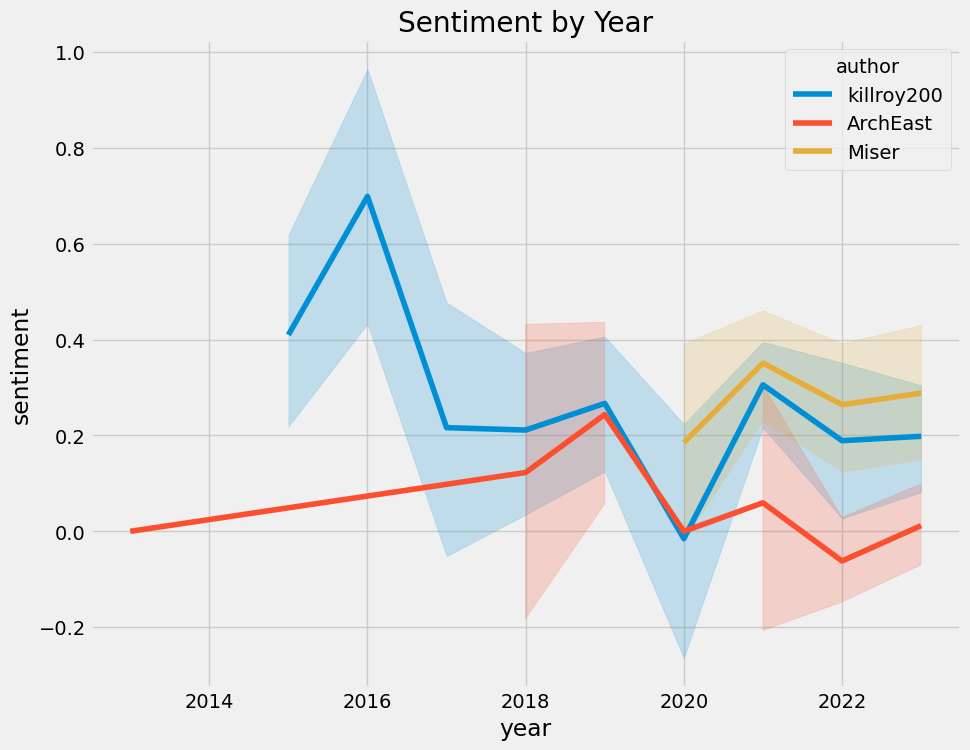

In [49]:
# plot sentiment by year for each user
plt.figure(figsize=(10, 8))
sns.lineplot(data=indepth_df, x="year", y="sentiment", hue="author")
plt.title("Sentiment by Year")
plt.show()

### Apply sentiment to the dataframe

In [45]:
# apply sentiment analysis to the comments
meta_comments_df["sentiment"] = meta_comments_df["body"].apply(get_sentiment)


In [50]:
meta_comments_df["bert_sentiment"] = meta_comments_df["body"].apply(bertSentiment)

In [85]:
meta_comments_df["bert_label"] = meta_comments_df["bert_sentiment"].apply(lambda x: "positive" if x > 0.5 else "negative")

In [ ]:
# export meta_comments_df to csv
#meta_comments_df.to_csv('metav2_comments_df.csv')

# read metav2_comments_df.csv
meta_comments_df = pd.read_csv('metav2_comments_df.csv', index_col=0)

In [22]:
filter = fltrd_users_df["user"]

# filter the meta_comments_df by the users in fltrd_users_df
select_comments_df = meta_comments_df[meta_comments_df["author"].isin(filter)]

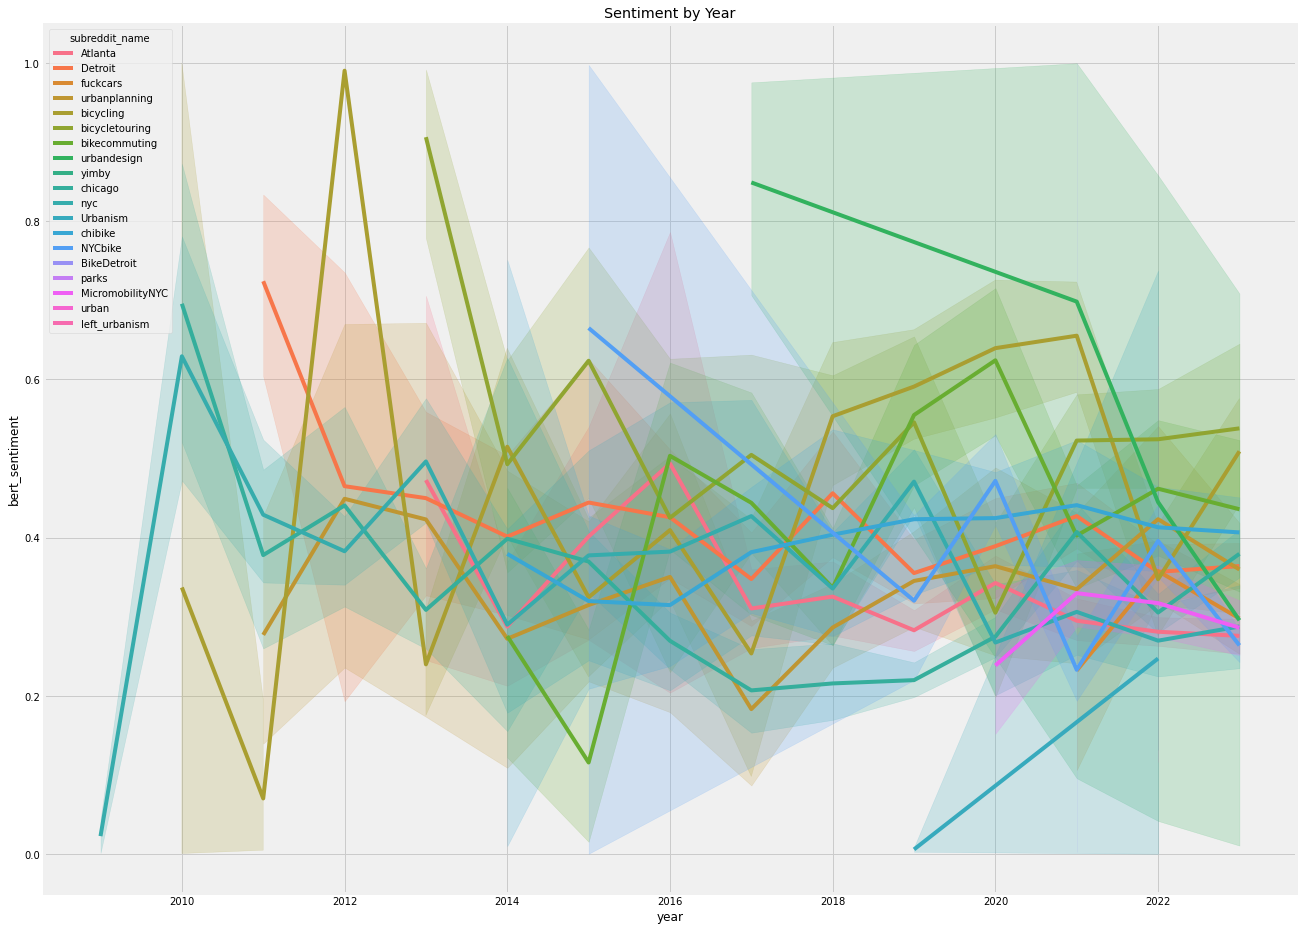

In [57]:
# use plotly to plot sns lineplot sentiment by year by subreddit


plt.figure(figsize=(20, 16))
sns.lineplot(data=select_comments_df, x="year", y="bert_sentiment", hue="subreddit_name")
plt.title("Sentiment by Year")
plt.show()



In [63]:
import plotly.graph_objects as go
import numpy as np
from scipy import stats

# Assuming df is your DataFrame and it includes columns 'year', 'sentiment', and 'subreddit'
df_grouped = select_comments_df.groupby(['year', 'subreddit_name'])['sentiment'].agg(['mean', 'count', 'std'])

# Calculate the confidence intervals
df_grouped['ci95_high'] = df_grouped['mean'] + 1.96*df_grouped['std']/np.sqrt(df_grouped['count'])
df_grouped['ci95_low'] = df_grouped['mean'] - 1.96*df_grouped['std']/np.sqrt(df_grouped['count'])
df_grouped.reset_index(inplace=True)

fig = go.Figure()

# Add one trace for each subreddit
for subreddit in df_grouped['subreddit_name'].unique():
    df_sub = df_grouped[df_grouped['subreddit_name'] == subreddit]
    fig.add_trace(go.Scatter(
        x=df_sub['year'], 
        y=df_sub['mean'], 
        mode='lines',
        name=subreddit,
        line_shape='spline'
    ))
    fig.add_trace(go.Scatter(
        x=df_sub['year'], 
        y=df_sub['ci95_high'], 
        mode='lines',
        line=dict(width=0),
        showlegend=False,
        name=f'{subreddit} upper',
        line_shape='spline'
    ))
    fig.add_trace(go.Scatter(
        x=df_sub['year'], 
        y=df_sub['ci95_low'], 
        mode='lines',
        line=dict(width=0),
        fill='tonexty',
        fillcolor='rgba(0,0,255,0.2)',
        showlegend=False,
        name=f'{subreddit} lower',
        line_shape='spline'
    ))

fig.show()

## Topic Clustering

### Finding the optimal number of topic clusters using topic coherence

In [59]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
import re

# Downloading NLTK stopwords
nltk.download('wordnet')

# Text preprocessing function
def preprocess(text):
    result = []
    lemmatizer = WordNetLemmatizer()
    for token in text.lower().split():
        token = re.sub(r'\W+', '', token)  # remove non-alphanumeric characters
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatizer.lemmatize(token))
    return result

# Preprocess the text data
processed_docs = meta_comments_df['body'].map(preprocess)

# Create a dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Create a bag-of-words model for each document
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Range of topic numbers to evaluate
topic_range = range(19,20)

# Store the models and their coherence scores
lda_models = []
coherence_scores = []

for num_topics in topic_range:
    # Create and train the LDA model
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0)
    lda_models.append(lda)

    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Prepare for plotting
topics_coherence = list(zip(topic_range, coherence_scores))

# Display the coherence scores
topics_coherence


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[(19, 0.5243763802191737)]

### Using Hierarchical Dirichlet Process (HDP) for finding optimal topics

In [ ]:
from gensim.models import HdpModel

# Training the HDP model
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

# Getting the topics from HDP
hdp_topics = hdp_model.show_topics(formatted=False)

# Determining the number of topics chosen by HDP
num_topics_hdp = len(hdp_topics)

# Displaying the number of topics and some topics as an example
num_topics_hdp, hdp_topics[:2]  # change hdp_topics to hdp_topics[:5] to see the first 5 topics


In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Text Preprocessing and Tokenization
# We use CountVectorizer for both tokenization and creating a document-term matrix
# We remove English stop words and limit the features to the top 1000 words for efficiency

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(meta_comments_df['body'])  # Document-term matrix

# Applying LDA

n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(dtm)

# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")

# Display the top 20 words for each topic
display_topics(lda, vectorizer.get_feature_names_out(), 20)

Topic 1:
bike trail ride way just cars path traffic park rail like road bikes beltline people lanes lane car use street
Topic 2:
https com www deleted org http reddit greenway chicago detroit maps park nyc google comments map new news miles link
Topic 3:
people city just don years think like atlanta new area going beltline money live want make lot public building work
Topic 4:
like just don people good know ve time really did think ll thanks great right got nice pretty love didn




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 37796 samples in 0.020s...
[t-SNE] Computed neighbors for 37796 samples in 0.613s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37796
[t-SNE] Computed conditional probabilities for sample 2000 / 37796
[t-SNE] Computed conditional probabilities for sample 3000 / 37796
[t-SNE] Computed conditional probabilities for sample 4000 / 37796
[t-SNE] Computed conditional probabilities for sample 5000 / 37796
[t-SNE] Computed conditional probabilities for sample 6000 / 37796
[t-SNE] Computed conditional probabilities for sample 7000 / 37796
[t-SNE] Computed conditional probabilities for sample 8000 / 37796
[t-SNE] Computed conditional probabilities for sample 9000 / 37796
[t-SNE] Computed conditional probabilities for sample 10000 / 37796
[t-SNE] Computed conditional probabilities for sample 11000 / 37796
[t-SNE] Computed conditional probabilities for sample 12000 / 37796
[t-SNE] Computed conditional probabilities for sam

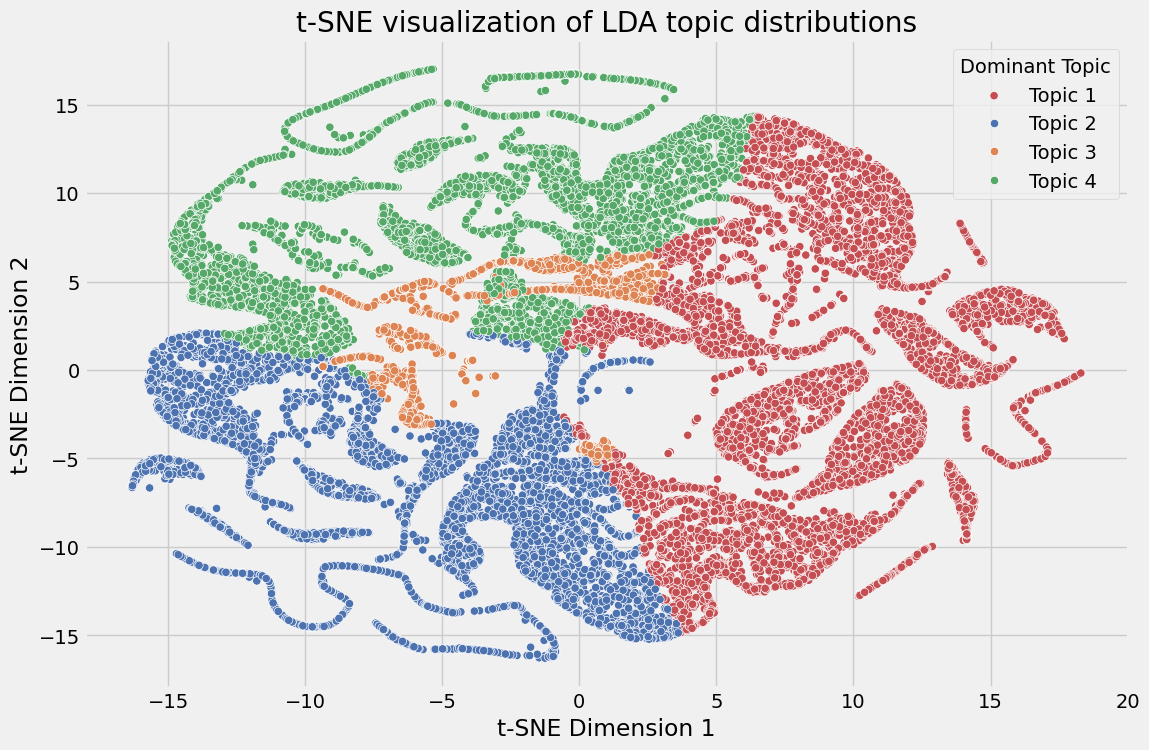

In [73]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Get the topic distribution for each comment
topic_distributions = lda.transform(dtm)

# t-SNE for dimensionality reduction to 2D
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=300)
tsne_lda = tsne_model.fit_transform(topic_distributions)

# Assign each comment to the most dominant topic
dominant_topic = np.argmax(topic_distributions, axis=1)

# Creating a scatter plot of the t-SNE output
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x=tsne_lda[:,0], y=tsne_lda[:,1], hue=dominant_topic, palette="deep", ax=ax)

ax.set_title('t-SNE visualization of LDA topic distributions')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
plt.legend(title='Dominant Topic', labels=[f'Topic {i+1}' for i in range(n_topics)])
plt.show()

### creating a keyword co-occurrence network

In [74]:
from collections import defaultdict
import itertools

# Step 1: Keyword Extraction
# We will use the most frequent terms in the dataset for simplicity. 
# Advanced methods like TF-IDF can also be used for more nuanced keyword extraction.

# Let's define a function to preprocess and extract keywords
def extract_keywords(text):
    # Basic preprocessing to tokenize and remove stop words
    tokens = preprocess(text)
    return tokens

# Extracting keywords from each comment
processed_comments = meta_comments_df['body'].map(extract_keywords)

# Counting word frequencies
word_freq = defaultdict(int)
for comment in processed_comments:
    for word in comment:
        word_freq[word] += 1

# Selecting top N keywords for the analysis
N = 100  # Number of top frequent words to consider
top_keywords = sorted(word_freq, key=word_freq.get, reverse=True)[:N]

# Step 2: Build Co-occurrence Matrix
# We'll define a function to update the co-occurrence matrix for each comment
def update_cooccurrence_matrix(matrix, comment, keywords):
    for word1, word2 in itertools.combinations(comment, 2):
        if word1 in keywords and word2 in keywords:
            matrix[word1][word2] += 1
            matrix[word2][word1] += 1

# Creating the co-occurrence matrix
cooccurrence_matrix = defaultdict(lambda: defaultdict(int))
for comment in processed_comments:
    update_cooccurrence_matrix(cooccurrence_matrix, comment, top_keywords)

# Convert cooccurrence_matrix to a format suitable for NetworkX
cooccurrence_data = [(word1, word2, cooccurrence_matrix[word1][word2]) 
                     for word1 in cooccurrence_matrix 
                     for word2 in cooccurrence_matrix[word1] 
                     if word1 != word2]

cooccurrence_data[:10]  # Display first 10 pairs 


[('ride', 'state', 110),
 ('ride', 'street', 466),
 ('ride', 'north', 268),
 ('ride', 'point', 190),
 ('ride', 'city', 495),
 ('ride', 'sure', 206),
 ('ride', 'stop', 215),
 ('ride', 'bike', 1759),
 ('ride', 'people', 693),
 ('ride', 'beltline', 138)]

In [76]:
heatmap_cooccurrence_data = {}

for entry in cooccurrence_data:
    heatmap_cooccurrence_data[(entry[0], entry[1])] = entry[2]

In [77]:
sorted_keys = sorted(heatmap_cooccurrence_data.items(), key=lambda item: item[1], reverse=True)

In [79]:
heatmap_cooccurrence_data = {}

for entry in sorted_keys[:100]:
    heatmap_cooccurrence_data[(entry[0][0], entry[0][1])] = entry[1]

Text(0.5, 1.0, 'Top 100 Co-occurrence Heatmap')

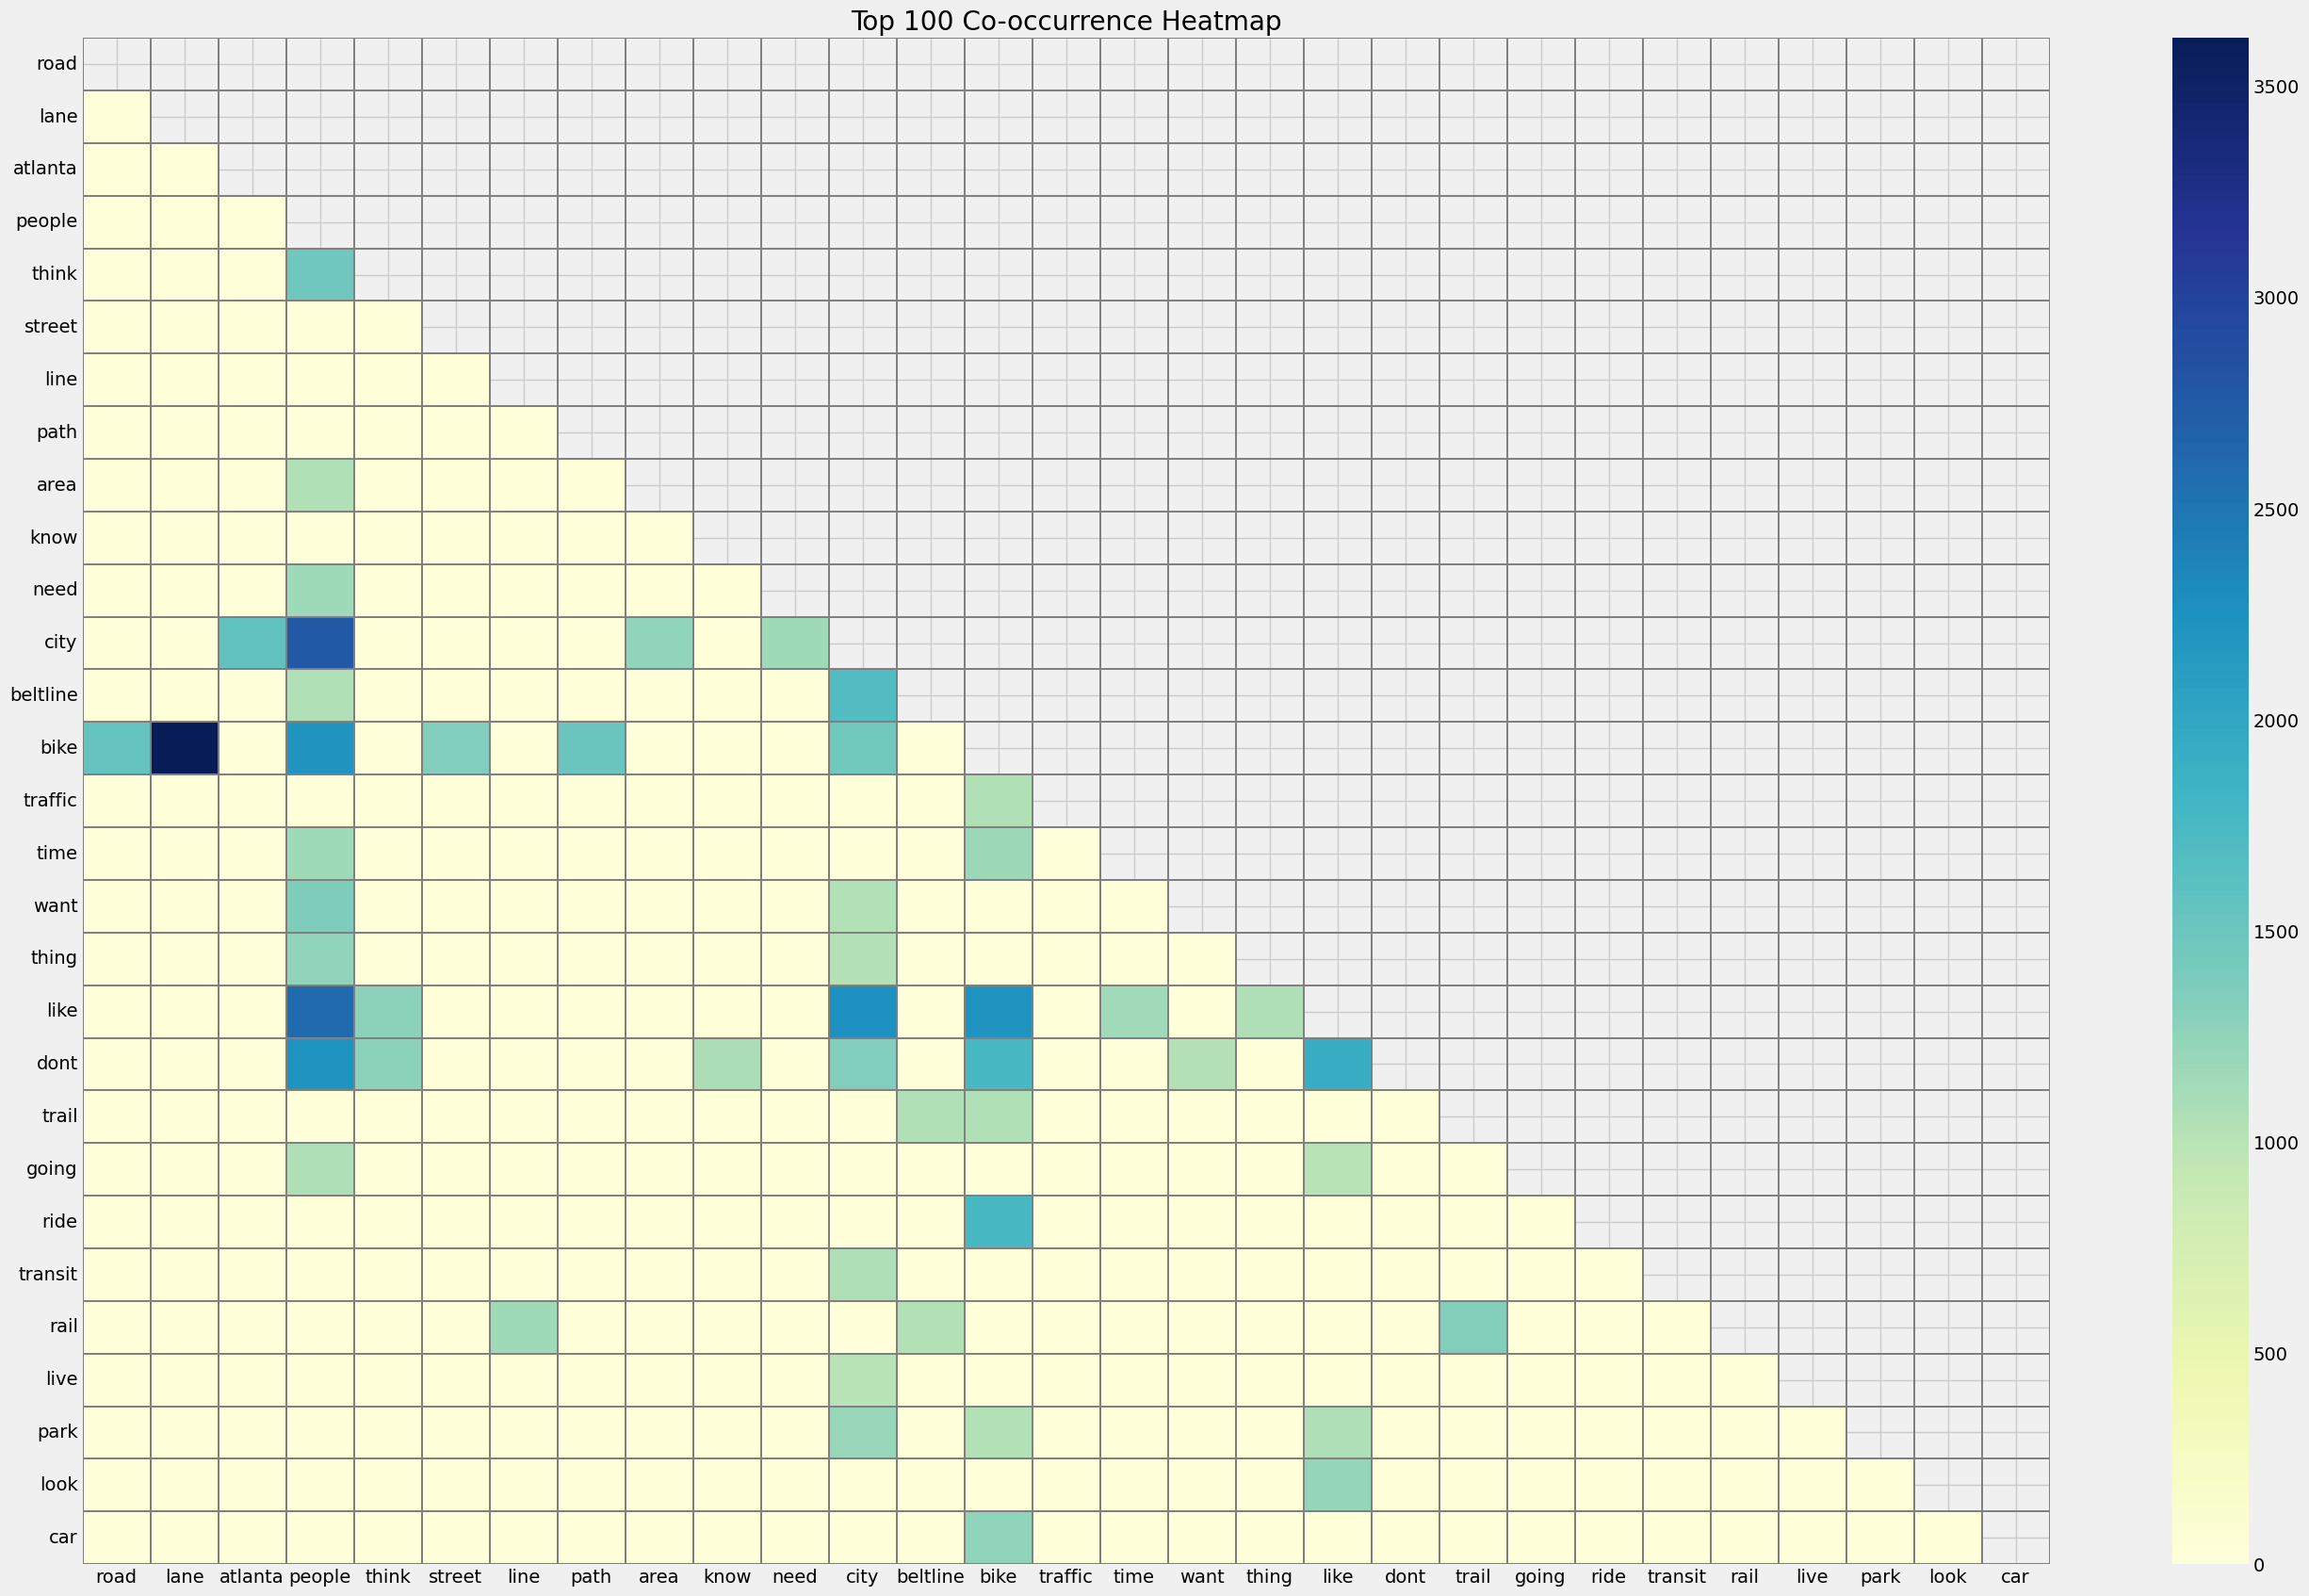

In [80]:
# creating a heatmap

import seaborn as sns
import pandas as pd


# Create a matrix
unique_words = set(word for pair in heatmap_cooccurrence_data for word in pair)
unique_words_list = list(unique_words)  # Convert set to list
cooccurrence_matrix = pd.DataFrame(0, index=unique_words_list, columns=unique_words_list)

for (word1, word2), freq in heatmap_cooccurrence_data.items():
    cooccurrence_matrix.at[word1, word2] = freq
    #cooccurrence_matrix.at[word2, word1] = freq

mask = np.triu(np.ones_like(cooccurrence_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(30, 20))

sns.heatmap(cooccurrence_matrix,mask=mask, cmap='YlGnBu', 
            linewidths=0.1, linecolor='gray')
plt.title('Top 100 Co-occurrence Heatmap')

### Building a Sentiment Interaction Network?

## 4 datasets for atl, chi, nyc and det 

build wordmap
topic clusterings and compare their topics clustering .. (topic cohesions?)

In [23]:
atl_tags = ["Atlanta", "beltine"]
chi_tags = ["Chicago","chibike", "606", "bloomingdale trail"]
det_tags = ["Detroit", "bikedetroit","Joe Louis Greenway", "dequindre cut"]
nyc_tags = ["NYC", "nycbike", "micromobilitynyc","highline"]


# get thread_ids for each city by tags
atl_thread_ids = []
chi_thread_ids = []
det_thread_ids = []
nyc_thread_ids = []

for index, entry in meta_df.iterrows():
    if any(tag in entry["tag"] for tag in atl_tags):
        atl_thread_ids.append(entry["id"])
    elif any(tag in entry["tag"] for tag in chi_tags):
        chi_thread_ids.append(entry["id"])
    elif any(tag in entry["tag"] for tag in det_tags):
        det_thread_ids.append(entry["id"])
    elif any(tag in entry["tag"] for tag in nyc_tags):
        nyc_thread_ids.append(entry["id"])
    
        # Extract the subreddit from the permalink
    subreddit_matches = re.findall(r'/r/([^/]+)', entry["permalink"])
    if not subreddit_matches:
        continue  # Skip this row if no subreddit is found
    subreddit = subreddit_matches[0]

    if subreddit in atl_tags:
        atl_thread_ids.append(entry["id"])
    elif subreddit in chi_tags:
        chi_thread_ids.append(entry["id"])
    elif subreddit in det_tags:
        det_thread_ids.append(entry["id"])
    elif subreddit in nyc_tags:
        nyc_thread_ids.append(entry["id"])

# build a dataframe of comments for each city
atl_comments_df = select_comments_df[select_comments_df["thread_id"].isin(atl_thread_ids)]
chi_comments_df = select_comments_df[select_comments_df["thread_id"].isin(chi_thread_ids)]
det_comments_df = select_comments_df[select_comments_df["thread_id"].isin(det_thread_ids)]
nyc_comments_df = select_comments_df[select_comments_df["thread_id"].isin(nyc_thread_ids)]


atl_comments_df["city_group"] = "Atlanta"
chi_comments_df["city_group"] = "Chicago"
det_comments_df["city_group"] = "Detroit"
nyc_comments_df["city_group"] = "NYC"

city_df = pd.concat([atl_comments_df, chi_comments_df, det_comments_df, nyc_comments_df])


C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2822120659.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2822120659.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2822120659.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

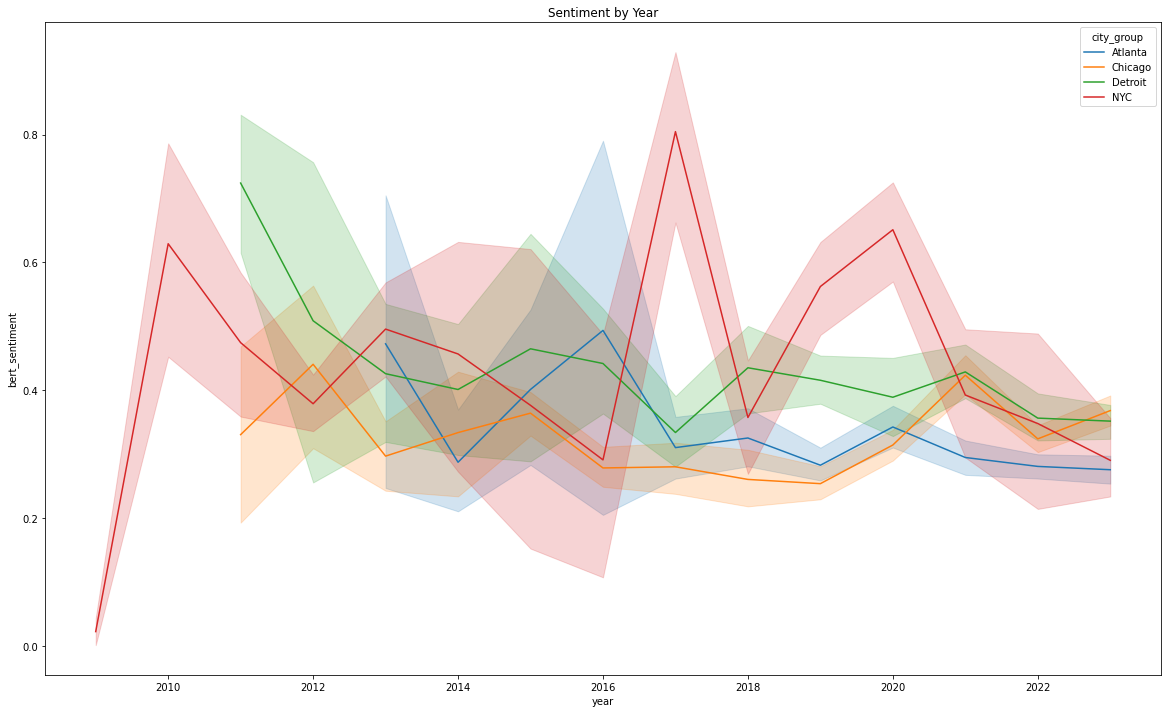

In [24]:
plt.figure(figsize=(20, 12))
# line plot width should be count of comments by city
sns.lineplot(data=city_df, x="year", y="bert_sentiment", hue="city_group")

plt.title("Sentiment by Year")
plt.show()

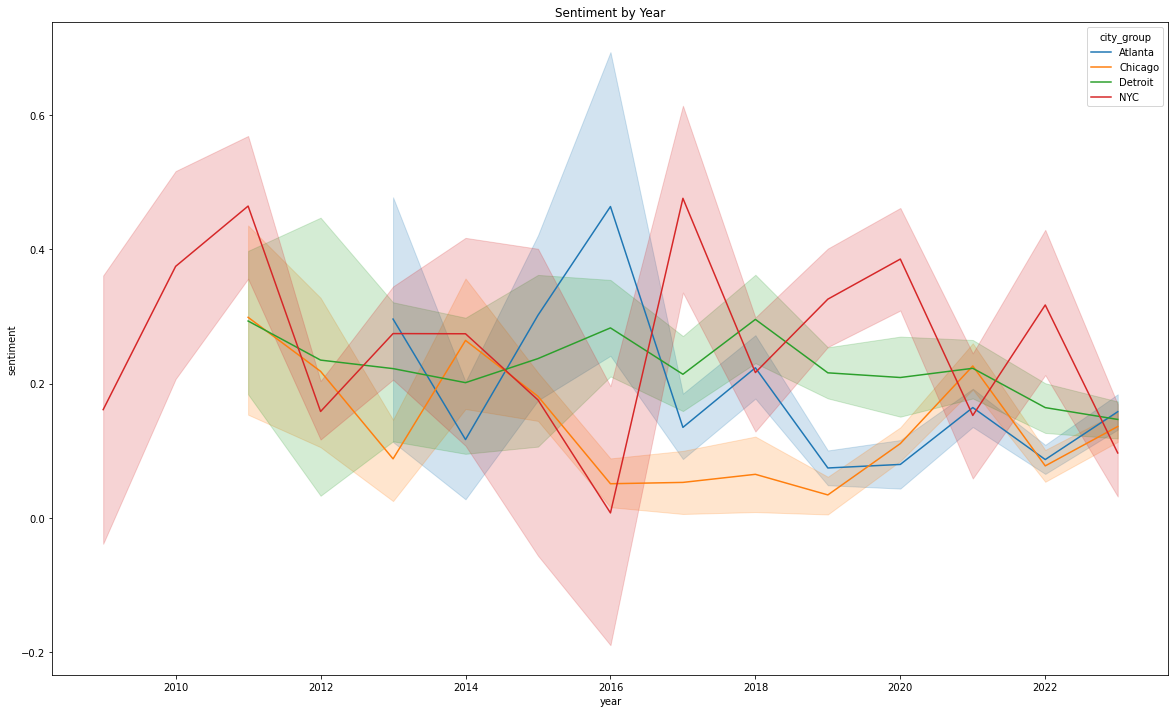

In [25]:
plt.figure(figsize=(20, 12))
# line plot width should be count of comments by city
sns.lineplot(data=city_df, x="year", y="sentiment", hue="city_group")

plt.title("Sentiment by Year")
plt.show()

## Build a wordmap

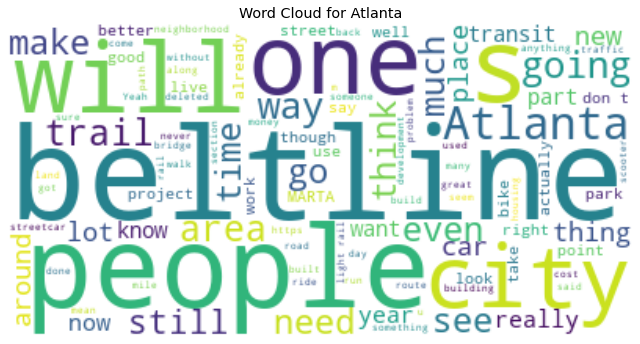

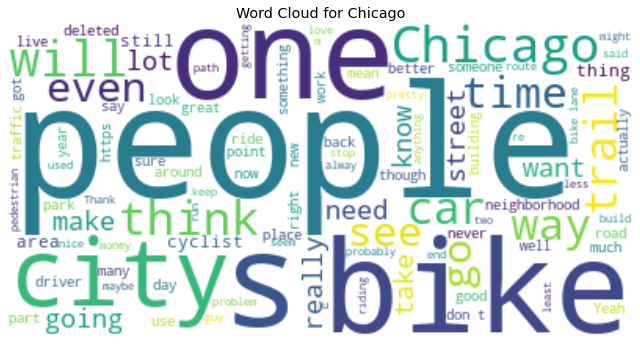

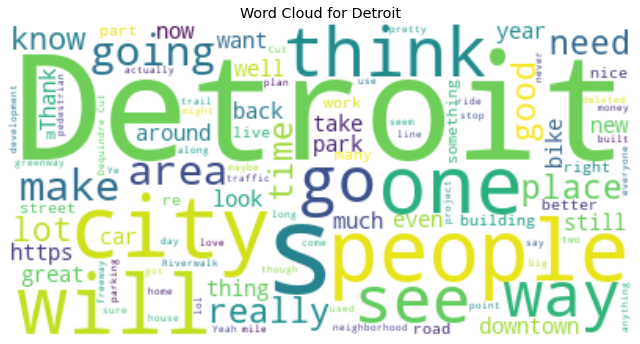

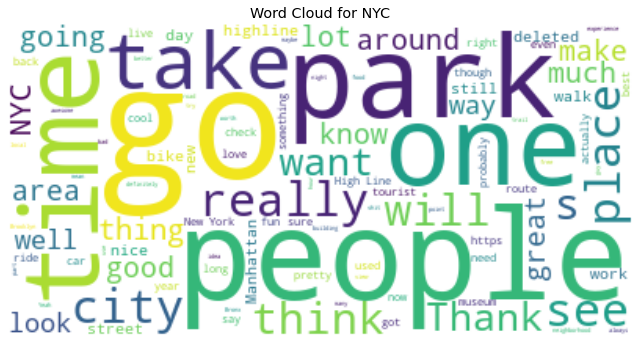

In [70]:
# build a word cloud for each city

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create a word cloud for each city for positive and negative sentiment


for city in city_df['city_group'].unique():
    # Combine all comments for the city into a single string
    text = ' '.join(city_df[city_df['city_group'] == city]['body'])
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {city}')
    plt.show()

## Building topic clustering for each city

In [78]:
def get_topic_clusters(text, topic_count):
    #vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

    dtm = vectorizer.fit_transform(text)  # Document-term matrix

    # Applying LDA

    n_topics = topic_count
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)

    display_topics(lda, vectorizer.get_feature_names_out(), 20)


In [79]:
get_topic_clusters(atl_comments_df["body"], 4)

Topic 1:
park just like deleted beltline going yeah traffic years area way piedmont bus route line station north really sure right
Topic 2:
https com bike beltline ve like atlanta www just trail creek time bridge day street org reddit scooters right great
Topic 3:
beltline rail transit trail city marta just light way streetcar like project land use tax going new atlanta housing construction
Topic 4:
people don just city like atlanta live want think beltline crime going make know need areas really say parking actually




In [80]:
get_topic_clusters(det_comments_df["body"], 4)

Topic 1:
https detroit com www park deleted joe greenway org trail louis reddit belle riverfront michigan great http isle way building
Topic 2:
just like think city people really don detroit going better new make lot way right ve area years ll nice
Topic 3:
detroit city people like cut don transit downtown good dequindre rail area thank know freeway live time just years midtown
Topic 4:
bike people like just tax don want ride parking time thanks yes going day detroit did lanes know traffic road




In [81]:
get_topic_clusters(chi_comments_df["body"], 4)

Topic 1:
bike just people like 606 ve ride time trail good pretty right path bikes got riding traffic going way yeah
Topic 2:
people don https chicago com just like www car think cars know doesn need bike org want does reddit way
Topic 3:
city deleted like bike just line going really right way think better long infrastructure make street chicago bridge river tracks
Topic 4:
park trail live people north new area city chicago like just don neighborhood removed housing want 606 property really lot




In [82]:
get_topic_clusters(nyc_comments_df["body"], 4)

Topic 1:
deleted like bike just city park don bronx time people new museum thanks ride great want island area ve car
Topic 2:
just like transit high line school people way bus public right walk cool live going station yeah better seattle don
Topic 3:
just time new really highline know great park brooklyn city east lot manhattan don nyc check good ll place bridge
Topic 4:
com http www people like https don just think reddit park line new high thank going org look doing nyc




2013
Topic 1:
greenway roswell 10 linked pssh really come com http www path people pretty hall kell don gsu garage parking
Topic 2:
path pretty www com http really people roswell come don hall kell pssh greenway linked gsu 10 garage parking
Topic 3:
parking garage people come don hall kell really roswell path pretty com www http pssh greenway gsu linked 10
Topic 4:
kell hall gsu don really people pretty garage parking path roswell come com www http pssh greenway linked 10


2014
Topic 1:
city mural just commercial people council application ordinance saying section make does artist area wall message 46 going artists walls
Topic 2:
beltline trail comet path don silver like connected just use road miles people speech need commercial bike think park good
Topic 3:
bike beltline lane deleted lanes ride people ve trail pedestrians right atlanta traffic left going bikers speed know slow roads
Topic 4:
like art beltline just new living path trail law city way bankhead speech development need m

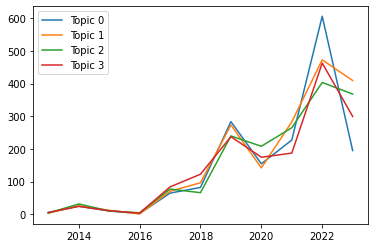

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import numpy as np

# Set the number of topics
n_topics = 4

# Create a CountVectorizer instance
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Group comments by month

grouped = atl_comments_df.groupby('year')

# Initialize a dictionary to store the prevalence of each topic over time
topic_prevalence = {i: [] for i in range(n_topics)}

# For each time period...
for time_period, group in grouped:
    # Perform LDA on the comments from this time period
    dtm = vectorizer.fit_transform(group['body'])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    print(time_period)
    display_topics(lda, vectorizer.get_feature_names_out(), 20)
    

    # For each topic...
    for topic in range(n_topics):
        # Calculate the prevalence of this topic in this time period
        prevalence = np.sum(lda.transform(dtm)[:, topic])

        # Store the prevalence
        topic_prevalence[topic].append(prevalence)

# Plot the prevalence of each topic over time
for topic in range(n_topics):
    plt.plot([group[0] for group in grouped], topic_prevalence[topic], label=f'Topic {topic}')
plt.legend()
plt.show()

In [144]:
from gensim.corpora import Dictionary

# Prepare texts
#texts = [group['body'].str.split().tolist() for _, group in atl_comments_df.groupby('year')]
texts = [sum(group['body'].str.split().tolist(), []) for _, group in atl_comments_df.groupby('year')]
# Create a dictionary representation of the documents
dictionary = Dictionary(texts)

# Filter out words that occur less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=2, no_above=0.5)

# Convert documents to a vectorized form by computing frequency of each word
corpus = [dictionary.doc2bow(text) for text in texts]

from gensim.models.wrappers import DtmModel

# Path to the dtm binary, which you'll have to download and install from https://github.com/magsilva/dtm
dtm_path = "D:\\dtm-master\\dtm-master\\bin\\dtm-win64.exe"

# Create a DTM model
# Create a DTM model
model = DtmModel(dtm_path, corpus, [len(texts)], num_topics=n_topics,
                 id2word=dictionary, initialize_lda=True)

# Get the topics



In [ ]:
topics = model.show_topic(topicid=2, time=0, topn=10)
topics

In [221]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import DtmModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
nltk.download('stopwords')

# Sort DataFrame by year
atl_comments_df = atl_comments_df.sort_values('year')

# Group DataFrame by year
grouped = atl_comments_df.groupby('year')

# Initialize a list to hold the corpus and a list to hold the timeslices
corpus = []
timeslices = []

# Initialize a dictionary
dictionary = Dictionary()

# For each year, create a BoW representation and add it to the corpus
for year, group in grouped:
    # Preprocess the text
    # Define the stop words
    stop_words = set(stopwords.words('english'))
    # Add custom stop words
    custom_stop_words = ["deleted", "also", "one", "would"]  # replace with your custom stop words
    stop_words.update(custom_stop_words)

    # Preprocess the text and remove stop words
    texts = group['body'].apply(lambda text: [word for word in simple_preprocess(text) if word not in stop_words])
    
    # Update the dictionary
    dictionary.add_documents(texts)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    
    # Create the BoW representation
    bow_texts = [dictionary.doc2bow(text) for text in texts]
    
    # Add the BoW representation to the corpus
    corpus.extend(bow_texts)
    
    # Add the number of documents to the timeslices
    timeslices.append(len(bow_texts))
    print("done")

# Now you can create your DTM model
dtm_path =  "D:\\dtm-master\\dtm-master\\bin\\dtm-win64.exe" # replace with the path to your DTM binary
model = DtmModel(dtm_path, corpus, timeslices, num_topics=4, id2word=dictionary, initialize_lda=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohsin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


done
done
done
done
done
done
done
done
done
done
done


In [236]:
model.show_topic(topicid=3
                 , time=10, topn=20)

[(0.018267252943986005, 'housing'),
 (0.017709494001744017, 'city'),
 (0.015103922009484056, 'tax'),
 (0.01371325480889903, 'transit'),
 (0.012715757681092147, 'beltline'),
 (0.012309494700629888, 'people'),
 (0.011857247608576453, 'development'),
 (0.011223392819190128, 'build'),
 (0.010649870458667035, 'affordable'),
 (0.010206822826657719, 'streetcar'),
 (0.009922368676925638, 'built'),
 (0.009469124755784243, 'crime'),
 (0.00915254799747858, 'land'),
 (0.00898241025141571, 'building'),
 (0.00894881463328227, 'atlanta'),
 (0.008723687315576285, 'property'),
 (0.008684034132630157, 'new'),
 (0.00834277220684594, 'need'),
 (0.008173405074660627, 'areas'),
 (0.007989686430305908, 'marta')]

In [228]:
timeslices

[17, 105, 42, 10, 295, 366, 1033, 678, 961, 1944, 1271]

In [495]:
meta_comments_df['year'].unique().max() + 1


2024

In [519]:
num_topics = 4

def plot_topic_proportions(df):
    df = df.sort_values('year')

    # Group DataFrame by year
    grouped = df.groupby('year')
        
    # Initialize a list to hold the corpus and a list to hold the timeslices
    corpus = []
    timeslices = []

    # Initialize a dictionary
    dictionary = Dictionary()

    # For each year, create a BoW representation and add it to the corpus
    for year, group in grouped:
        # Preprocess the text
        # Define the stop words
        stop_words = set(stopwords.words('english'))
        # Add custom stop words
        custom_stop_words = ["deleted", "also", "one", "would"]  # replace with your custom stop words
        stop_words.update(custom_stop_words)

        # Preprocess the text and remove stop words
        texts = group['body'].apply(lambda text: [word for word in simple_preprocess(text) if word not in stop_words])
        
        # Update the dictionary
        dictionary.add_documents(texts)
        dictionary.filter_extremes(no_below=20, no_above=0.5)
        
        # Create the BoW representation
        bow_texts = [dictionary.doc2bow(text) for text in texts]
        
        # Add the BoW representation to the corpus
        corpus.extend(bow_texts)
        
        # Add the number of documents to the timeslices
        timeslices.append(len(bow_texts))


    # Now you can create your DTM model
    dtm_path =  "D:\\dtm-master\\dtm-master\\bin\\dtm-win64.exe" # replace with the path to your DTM binary
    model = DtmModel(dtm_path, corpus, timeslices, num_topics=4, id2word=dictionary, initialize_lda=True)
    
    
    # Get the topic proportions for all documents
    topic_proportions = model.gamma_ / np.sum(model.gamma_, axis=1, keepdims=True)

    # Initialize a list to hold the topic sizes for each year
    topic_sizes_per_year = []

    # Initialize a counter for the current document
    doc_counter = 0

    # For each year, sum up the topic proportions
    for year, num_docs in enumerate(timeslices):
        # Initialize a list to hold the topic sizes for this year
        topic_sizes = [0] * num_topics

        # Sum up the topic proportions for this year
        for _ in range(num_docs):
            doc_topics = topic_proportions[doc_counter]
            for topic, proportion in enumerate(doc_topics):
                topic_sizes[topic] += proportion
            doc_counter += 1

        # Add the topic sizes for this year to the list
        topic_sizes_per_year.append(topic_sizes)


    # Convert the topic sizes to proportions
    topic_proportions_per_year = topic_sizes_per_year / np.sum(topic_sizes_per_year, axis=1, keepdims=True)
    plt.figure(figsize=(15, 10))
    # Create a line plot for each topic
    for i in range(num_topics):
        plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, i], label='Topic {}'.format(i))

    

    years = list(range(df['year'].unique().min(), 2024))  # replace with your actual years

    # Set x-ticks
    plt.xticks(range(len(years)), years)
    # Add labels and a legend
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.legend()
    plt.title("Topic Proportions Over Time for 'Rails to Trails' in Detroit Subreddits")

    # Show the plot
    plt.show()

    return model




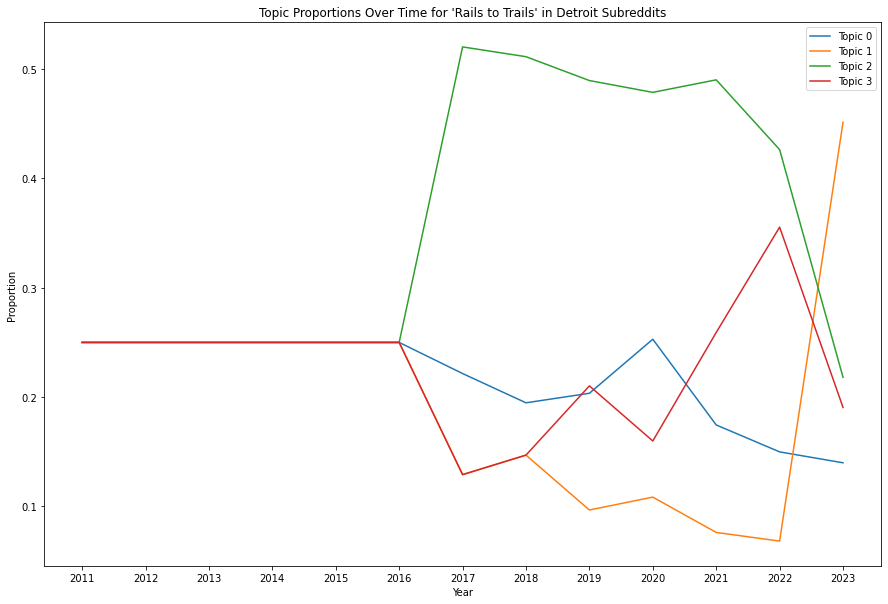

In [520]:
model = plot_topic_proportions(det_comments_df)

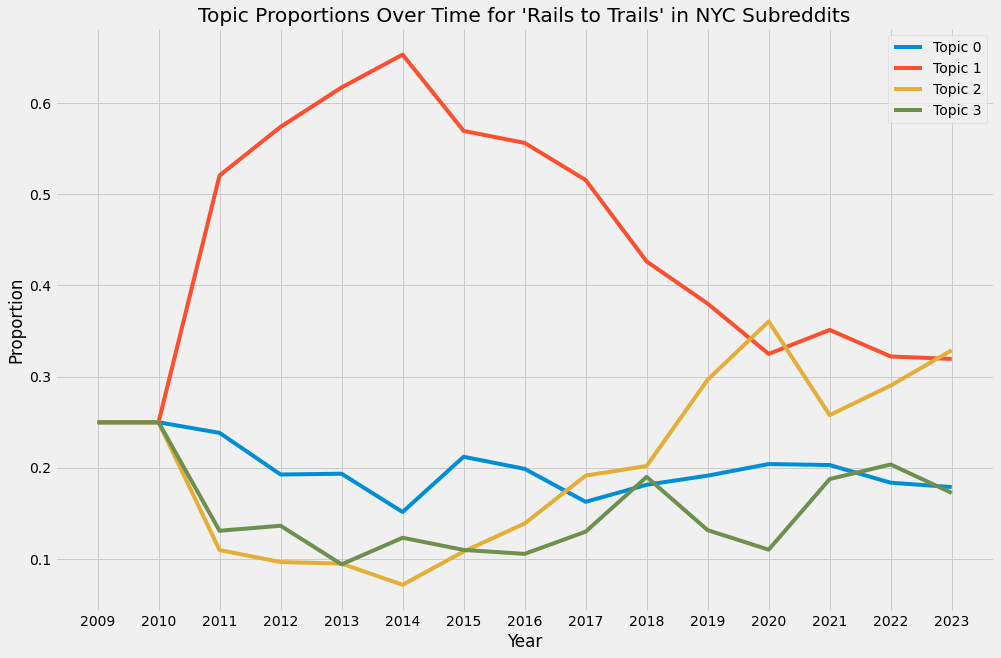

In [584]:

df = meta_comments_df

df = df.sort_values('year')

# Group DataFrame by year
grouped = df.groupby('year')
    
# Initialize a list to hold the corpus and a list to hold the timeslices
corpus = []
timeslices = []

# Initialize a dictionary
dictionary = Dictionary()

# For each year, create a BoW representation and add it to the corpus
for year, group in grouped:
    # Preprocess the text
    # Define the stop words
    stop_words = set(stopwords.words('english'))
    # Add custom stop words
    custom_stop_words = ["deleted", "also", "one", "would"]  # replace with your custom stop words
    stop_words.update(custom_stop_words)

    # Preprocess the text and remove stop words
    texts = group['body'].apply(lambda text: [word for word in simple_preprocess(text) if word not in stop_words])
    
    # Update the dictionary
    dictionary.add_documents(texts)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    
    # Create the BoW representation
    bow_texts = [dictionary.doc2bow(text) for text in texts]
    
    # Add the BoW representation to the corpus
    corpus.extend(bow_texts)
    
    # Add the number of documents to the timeslices
    timeslices.append(len(bow_texts))


# Now you can create your DTM model
dtm_path =  "D:\\dtm-master\\dtm-master\\bin\\dtm-win64.exe" # replace with the path to your DTM binary
#model = DtmModel(dtm_path, corpus, timeslices, num_topics=4, id2word=dictionary, initialize_lda=True)

model = meta_model

# Get the topic proportions for all documents
topic_proportions = model.gamma_ / np.sum(model.gamma_, axis=1, keepdims=True)

# Initialize a list to hold the topic sizes for each year
topic_sizes_per_year = []

# Initialize a counter for the current document
doc_counter = 0

# For each year, sum up the topic proportions
for year, num_docs in enumerate(timeslices):
    # Initialize a list to hold the topic sizes for this year
    topic_sizes = [0] * num_topics

    # Sum up the topic proportions for this year
    for _ in range(num_docs):
        doc_topics = topic_proportions[doc_counter]
        for topic, proportion in enumerate(doc_topics):
            topic_sizes[topic] += proportion
        doc_counter += 1

    # Add the topic sizes for this year to the list
    topic_sizes_per_year.append(topic_sizes)


# Convert the topic sizes to proportions
topic_proportions_per_year = topic_sizes_per_year / np.sum(topic_sizes_per_year, axis=1, keepdims=True)
plt.figure(figsize=(15, 10))
# Create a line plot for each topic
for i in range(num_topics):
    plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, i], label='Topic {}'.format(i))



years = list(range(df['year'].unique().min(), 2024))  # replace with your actual years

# Set x-ticks
plt.xticks(range(len(years)), years)
# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend()
plt.title("Topic Proportions Over Time for 'Rails to Trails' in NYC Subreddits")

# Show the plot
plt.show()

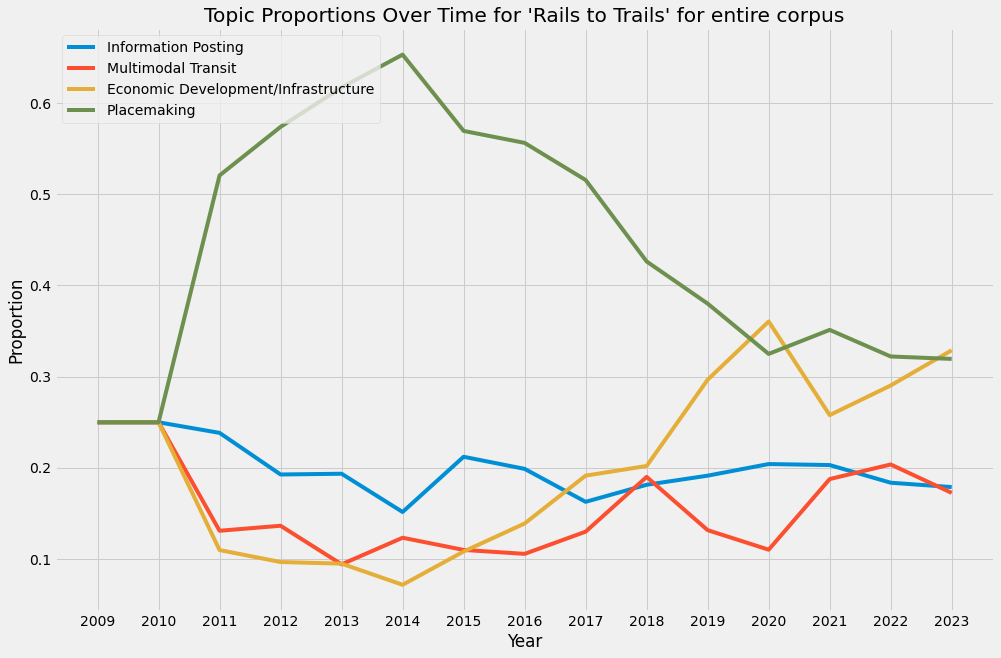

In [591]:
plt.figure(figsize=(15, 10))
# Create a line plot for each topic

plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, 0], label='Information Posting')

plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, 3], label='Multimodal Transit')


plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, 2], label='Economic Development/Infrastructure')



plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, 1], label="Placemaking")





years = list(range(df['year'].unique().min(), 2024))  # replace with your actual years

#change color of plot
plt.style.use('fivethirtyeight')

# assign custom names to legend labels
plt.legend(loc='upper left', )

# Set x-ticks
plt.xticks(range(len(years)), years)
# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(loc='upper left')
plt.title("Topic Proportions Over Time for 'Rails to Trails' for entire corpus")

# Show the plot
plt.show()

In [590]:
model.show_topic(topicid=3
                 , time=9, topn=20)

[(0.04429769524558069, 'city'),
 (0.04202375573002787, 'beltline'),
 (0.023344593344082742, 'atlanta'),
 (0.020655153091442304, 'new'),
 (0.02028979327523703, 'rail'),
 (0.01935652307739147, 'transit'),
 (0.01613978784394198, 'line'),
 (0.012177213665260398, 'trail'),
 (0.009712531931528, 'use'),
 (0.009030917662413469, 'high'),
 (0.008874117811358152, 'like'),
 (0.008768733525692005, 'light'),
 (0.008459559136150657, 'could'),
 (0.008069534386038552, 'way'),
 (0.007660525180423653, 'marta'),
 (0.007603056218386421, 'area'),
 (0.007212756881948139, 'parking'),
 (0.007136734079466126, 'much'),
 (0.006844744611030045, 'already'),
 (0.006582797540984433, 'along')]

In [276]:
def get_best_model(df):
    print("Model 0")
    model1 = plot_topic_proportions(df)

    print("Model 1")
    model2 = plot_topic_proportions(df)

    print("Model 2")
    model3 = plot_topic_proportions(df)

    print("Model 3")
    model4 = plot_topic_proportions(df)

    print("Model 4")
    model5 = plot_topic_proportions(df)

    print("Model 5")
    model6 = plot_topic_proportions(df)

    print("Model 6")
    model7 = plot_topic_proportions(df)
    
    print("Model 7")
    model8 = plot_topic_proportions(df)

    print("Model 8")
    model9 = plot_topic_proportions(df)

    print("Model 9")
    model10 = plot_topic_proportions(df)

    return model1, model2, model3, model4, model5, model6, model7, model8, model9, model10


Model 0


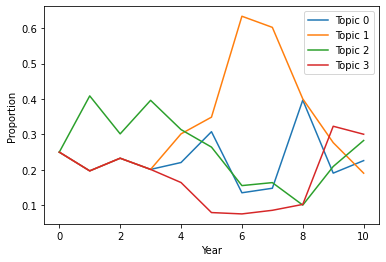

Model 1


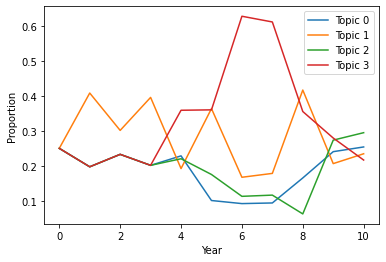

Model 2


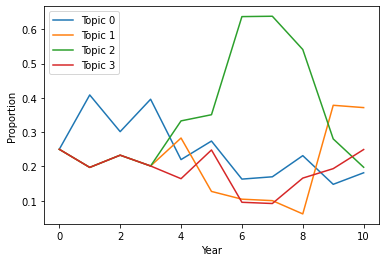

Model 3


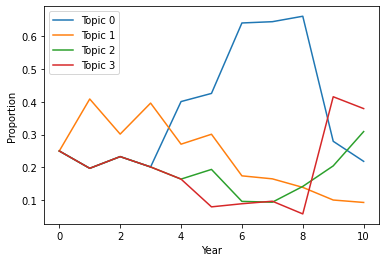

Model 4


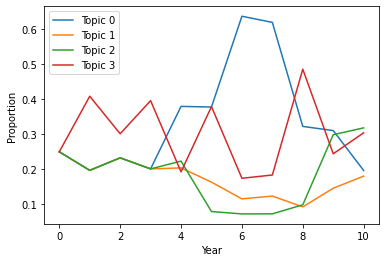

Model 5


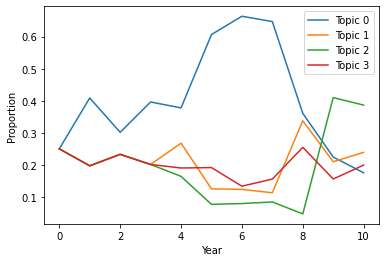

Model 6


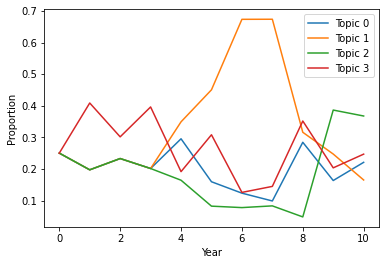

Model 7


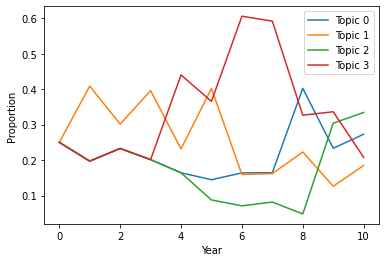

Model 8


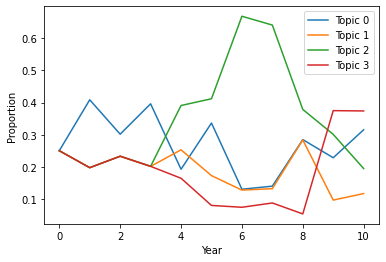

Model 9


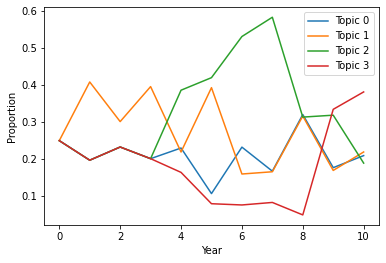

In [299]:
atl_models = get_best_model(atl_comments_df)

Model 0


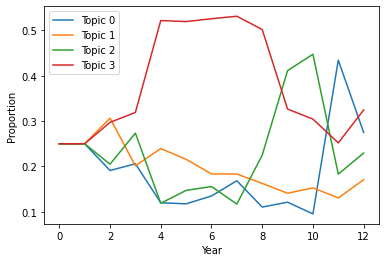

Model 1


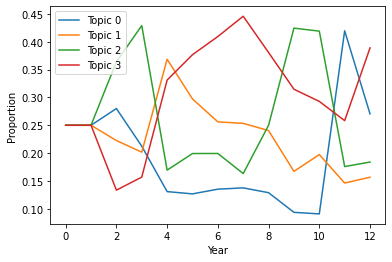

Model 2


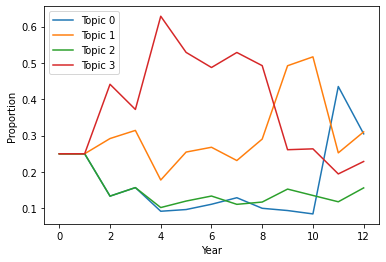

Model 3


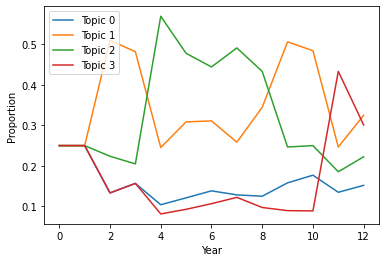

Model 4


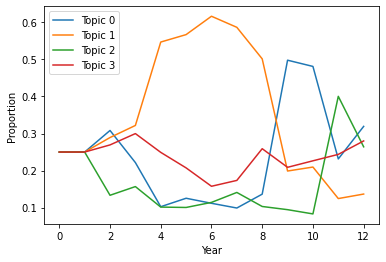

Model 5


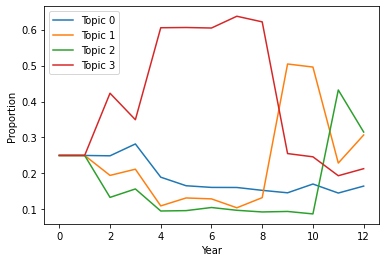

Model 6


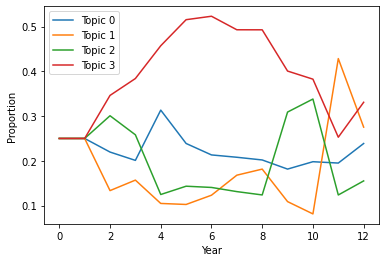

Model 7


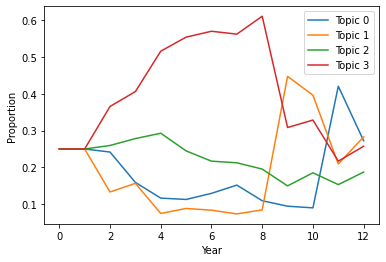

Model 8


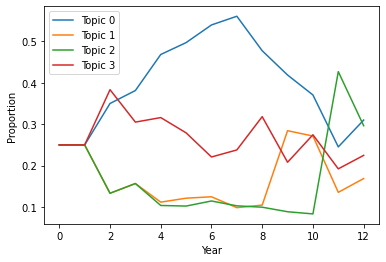

Model 9


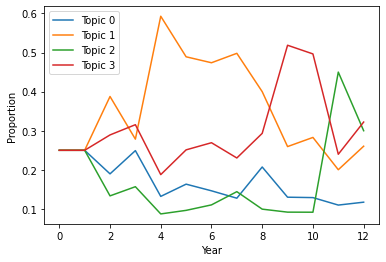

In [300]:
chi_models = get_best_model(chi_comments_df)

Model 0


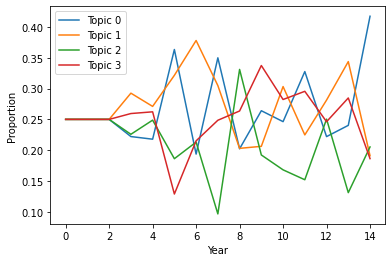

Model 1


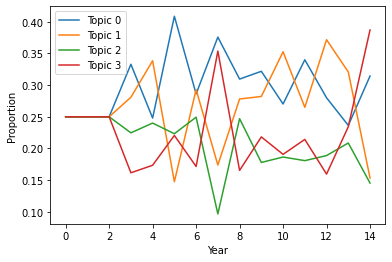

Model 2


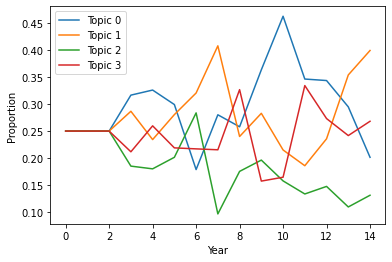

Model 3


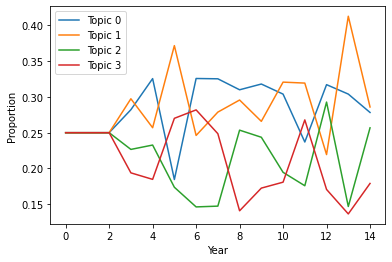

Model 4


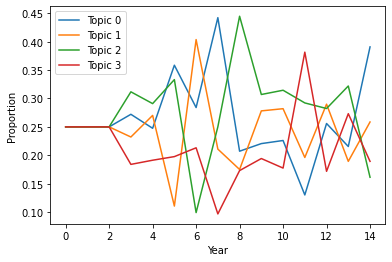

Model 5


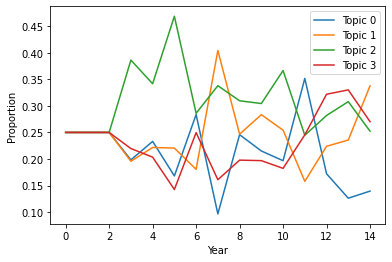

Model 6


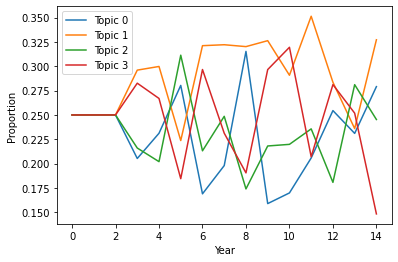

Model 7


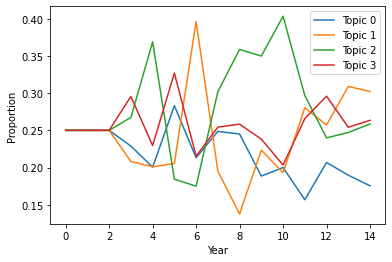

Model 8


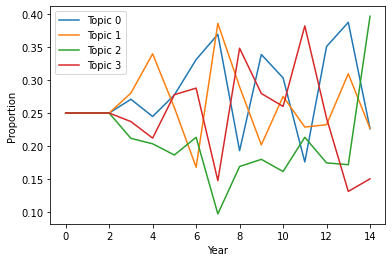

Model 9


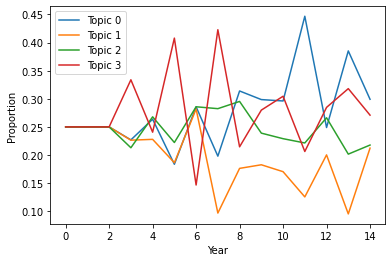

In [301]:
nyc_models = get_best_model(nyc_comments_df)

Model 0


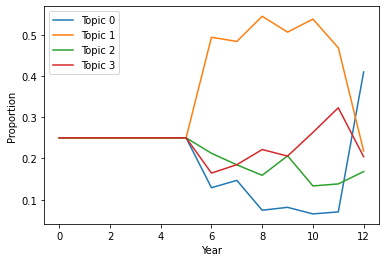

Model 1


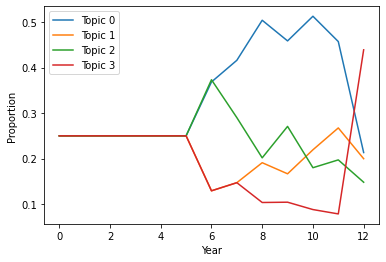

Model 2


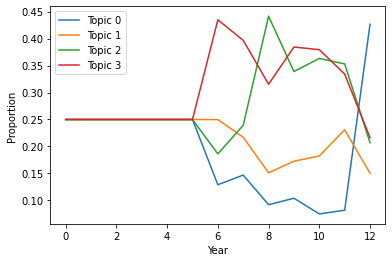

Model 3


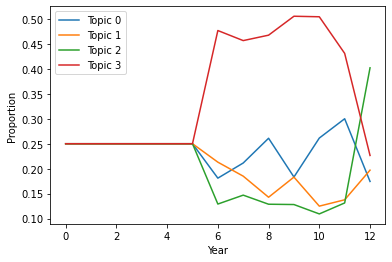

Model 4


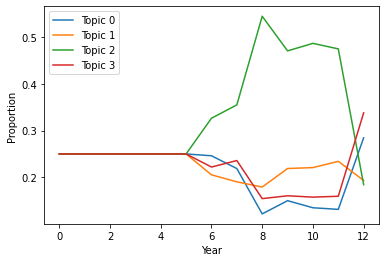

Model 5


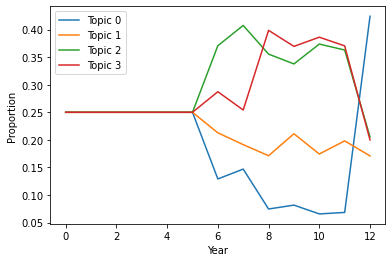

Model 6


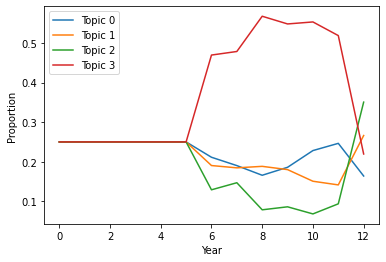

Model 7


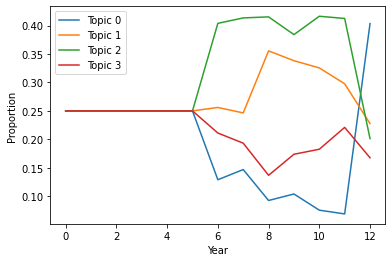

Model 8


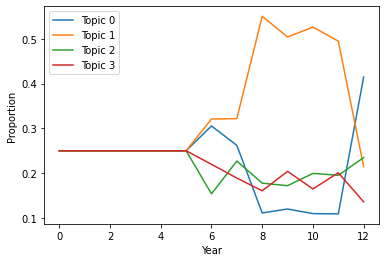

Model 9


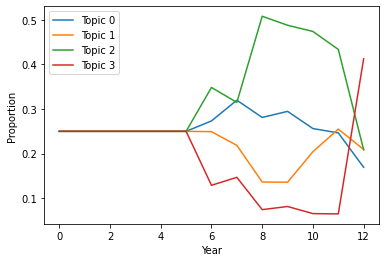

In [302]:
det_models = get_best_model(det_comments_df)

In [293]:
test1[0].show_topic(topicid=3, time=10, topn=20)


[(0.050884287828172774, 'people'),
 (0.028741898098231047, 'get'),
 (0.02839650861818371, 'like'),
 (0.01802276613760102, 'beltline'),
 (0.01799808257173386, 'car'),
 (0.01672860290056774, 'bike'),
 (0.016640745086420824, 'think'),
 (0.015368317015978869, 'go'),
 (0.015074327364254618, 'even'),
 (0.01452465327313849, 'going'),
 (0.013851807943289041, 'traffic'),
 (0.01374793021862558, 'know'),
 (0.0133177172481232, 'city'),
 (0.013040407085140584, 'way'),
 (0.012919422877098964, 'see'),
 (0.012900611434012403, 'much'),
 (0.012150721695327542, 'time'),
 (0.012094802776459116, 'make'),
 (0.01199889201943913, 'really'),
 (0.011965432682179077, 'good')]

In [292]:
test1[0].show_topic(topicid=2, time=10, topn=20)


[(0.030423282379145072, 'years'),
 (0.02292489209308346, 'like'),
 (0.014409694079112995, 'new'),
 (0.012533187186286978, 'time'),
 (0.011813046075489388, 'beltline'),
 (0.011594810081146722, 'going'),
 (0.011519443788173753, 'yeah'),
 (0.011422820790023379, 'area'),
 (0.011404265263676851, 'right'),
 (0.011194476026926529, 'still'),
 (0.010268628999872522, 'never'),
 (0.010063071390182192, 'last'),
 (0.009954921551542827, 'back'),
 (0.009947208983544101, 'construction'),
 (0.009896432409268912, 'get'),
 (0.009671937814033334, 'place'),
 (0.009285040063435045, 'great'),
 (0.009147854191757343, 'see'),
 (0.00911478223765521, 'two'),
 (0.008965890250879757, 'storage')]

In [294]:
test1[0].show_topic(topicid=1, time=10, topn=20)


[(0.03282955453052184, 'city'),
 (0.026348448858668314, 'people'),
 (0.018785071198887837, 'housing'),
 (0.016793737724053518, 'atlanta'),
 (0.014002851673527593, 'beltline'),
 (0.013338788600194837, 'like'),
 (0.011919826269919125, 'tax'),
 (0.01118677558234561, 'want'),
 (0.010559051193868218, 'development'),
 (0.009964101682397478, 'land'),
 (0.009165361369734873, 'areas'),
 (0.009134852734340991, 'live'),
 (0.008786461042227165, 'affordable'),
 (0.008734457899167325, 'build'),
 (0.008628965831779509, 'going'),
 (0.008349469052726368, 'new'),
 (0.008087118999461549, 'even'),
 (0.00794636165022539, 'money'),
 (0.00787561894790095, 'need'),
 (0.0074408747654093, 'building')]

In [295]:
test1[0].show_topic(topicid=0, time=10, topn=20)


[(0.062964814922689, 'beltline'),
 (0.0408094064728117, 'rail'),
 (0.03779431920941372, 'trail'),
 (0.027085708922457527, 'transit'),
 (0.021234676332164217, 'https'),
 (0.020328874549374928, 'park'),
 (0.018537740544802735, 'atlanta'),
 (0.01659373107568897, 'com'),
 (0.01583369471929736, 'light'),
 (0.014588373723010875, 'marta'),
 (0.013486216410385698, 'way'),
 (0.011525327563386593, 'line'),
 (0.011400827124292369, 'like'),
 (0.011254697540777186, 'path'),
 (0.010755748765592548, 'along'),
 (0.00996492073840293, 'route'),
 (0.009924143188402523, 'www'),
 (0.00916066045192279, 'streetcar'),
 (0.008983982929636342, 'project'),
 (0.00890679627928527, 'much')]

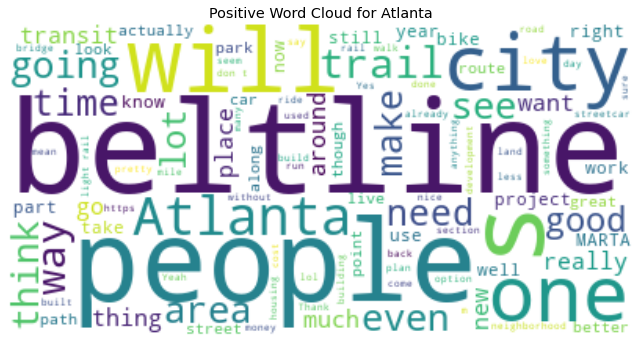

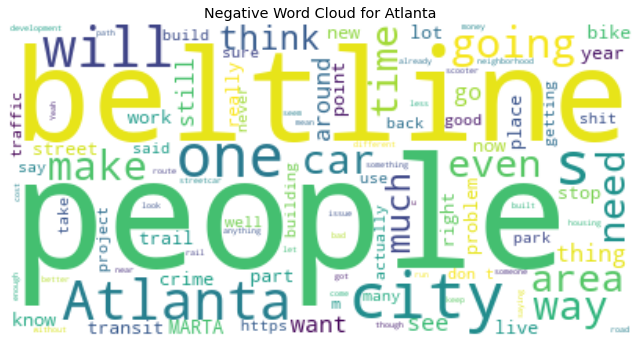

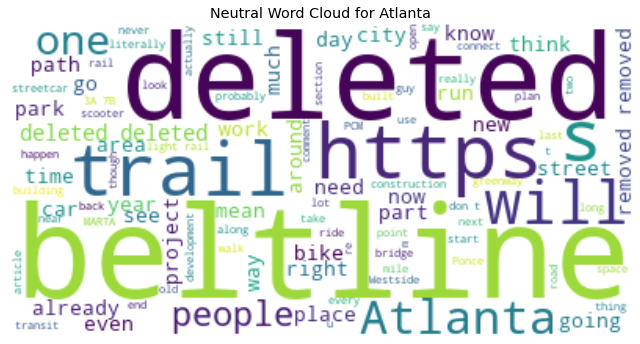

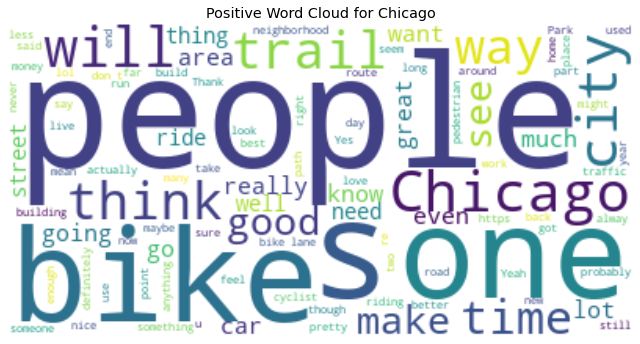

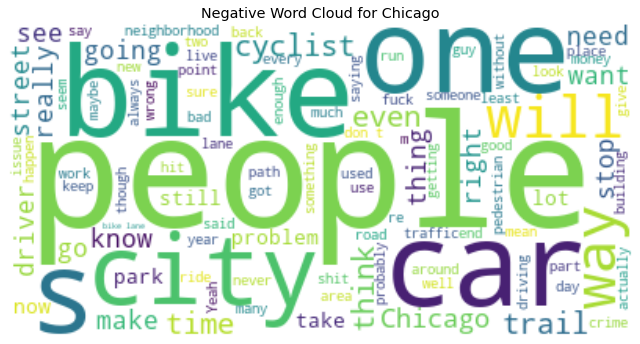

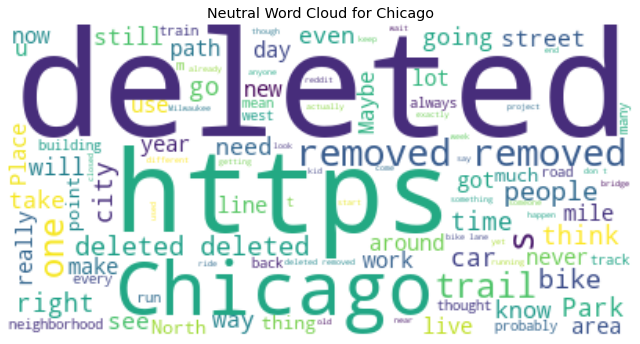

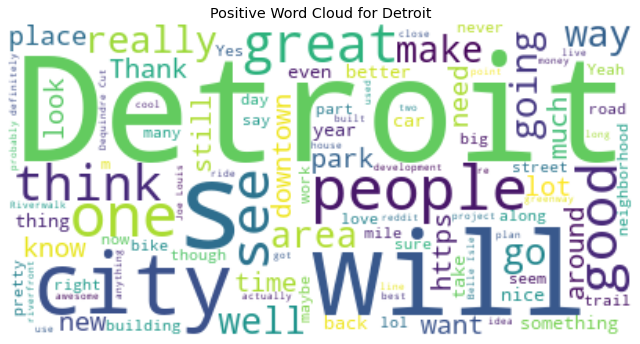

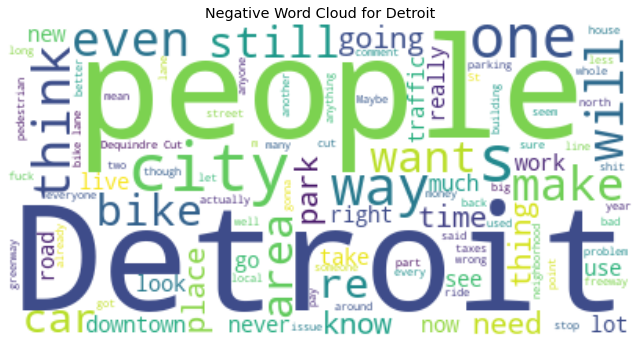

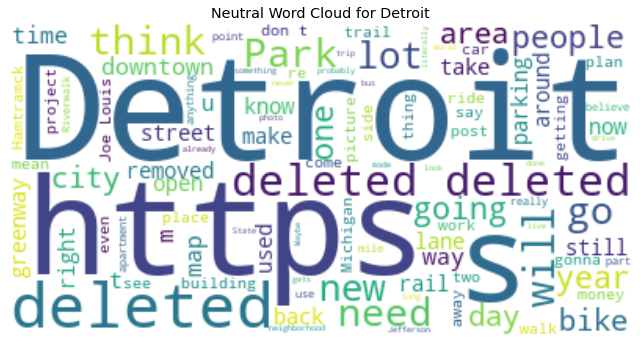

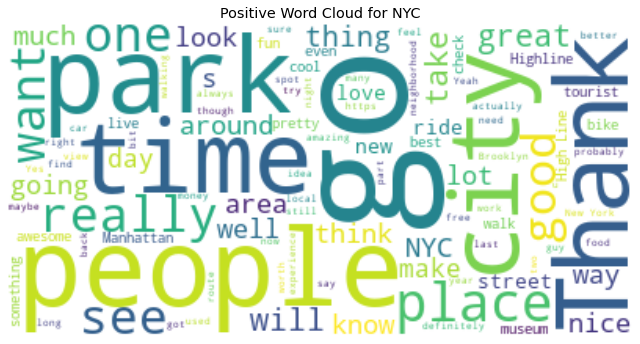

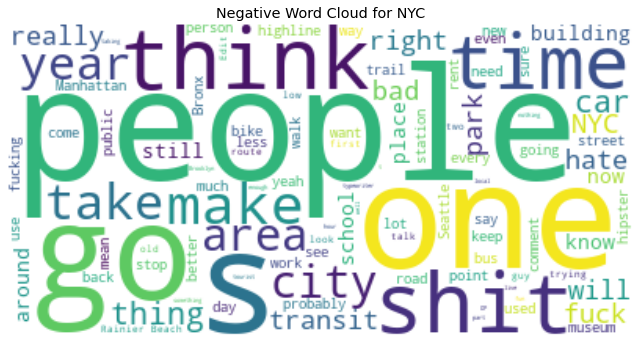

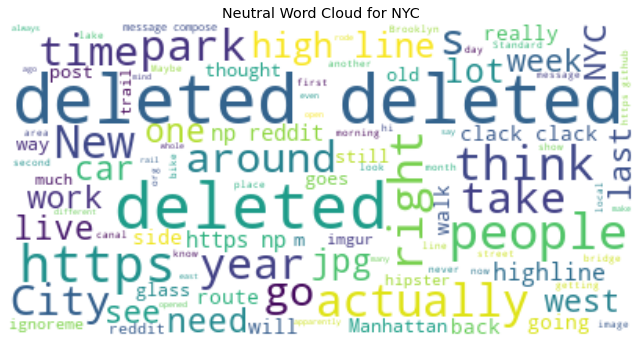

In [90]:
# get wordcloud for each city based on negative and postive labels
for city in city_df['city_group'].unique():
    # Combine all comments for the city into a single string if bert_label is positive
    text = ' '.join(city_df[(city_df['city_group'] == city) & (city_df["sentiment"] > 0)]['body'])
    # Create and generate a word cloud image
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Positive Word Cloud for {city}')
    plt.show()


    # Combine all comments for the city into a single string if bert_label is positive
    text = ' '.join(city_df[(city_df['city_group'] == city) & (city_df["sentiment"] < 0)]['body'])
    # Create and generate a word cloud image
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Negative Word Cloud for {city}')
    plt.show()


    # Combine all comments for the city into a single string if bert_label is positive
    text = ' '.join(city_df[(city_df['city_group'] == city) & (city_df["sentiment"] == 0)]['body'])
    # Create and generate a word cloud image
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Neutral Word Cloud for {city}')
    plt.show()



### Semantic Interaction Network

In [429]:
test_df = meta_comments_df[meta_comments_df["year"] == 2012]

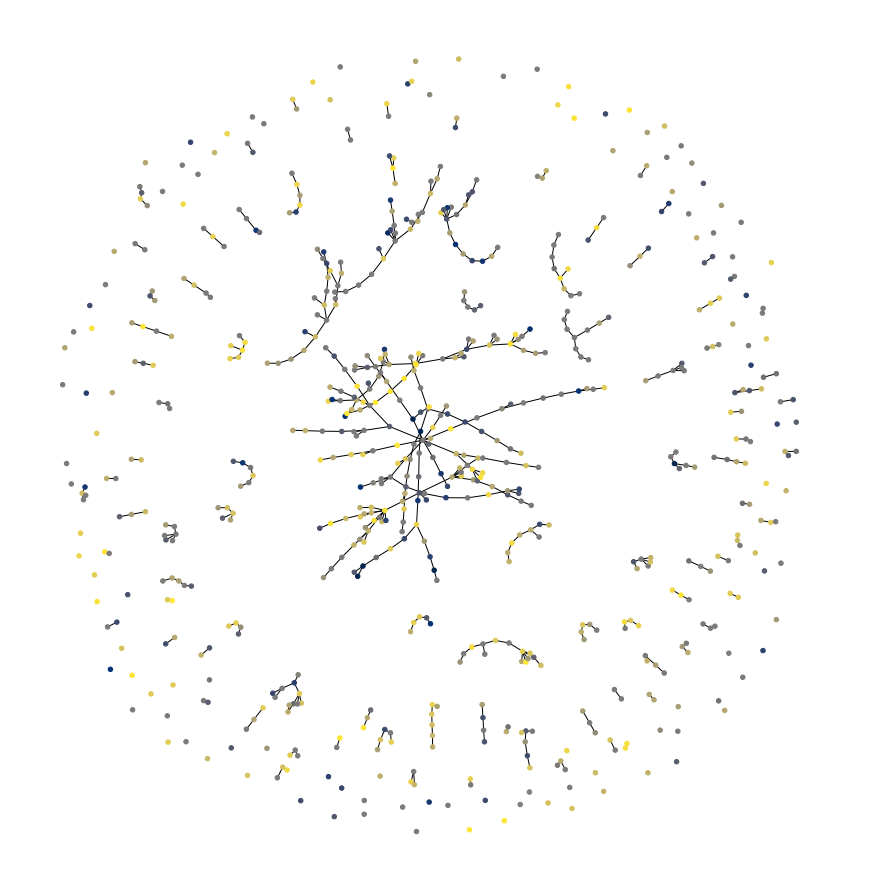

{'Number of Nodes': 688,
 'Number of Edges': 474,
 'Average Degree': 1.377906976744186,
 'Top 20 Central Nodes': ['c5x3gio',
  'c5vlcaw',
  'c5vm429',
  'c5x1or5',
  'c5x9c3a',
  'c3izicl',
  'c5x0y2y',
  'c5x5bho',
  'c5vc0ix',
  'c5vemsz']}

In [430]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Assuming comments_df is your loaded DataFrame

# Create the graph
G = nx.Graph()

# Add nodes with sentiment as an attribute
for index, row in test_df.iterrows():
    G.add_node(row['comment_id'], sentiment=row['sentiment'])

# Add edges based on parent_id
for index, row in test_df.iterrows():
    if pd.notna(row['parent_id']) and row['parent_id'] in G:
        G.add_edge(row['comment_id'], row['parent_id'], arrows="to")

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, node_size=20, node_color=[data['sentiment'] for _, data in G.nodes(data=True)])
plt.show()

# Step 2: Analyze the Network
# Calculating basic network properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(dict(G.degree()).values()) / num_nodes

# Calculating degree centrality
degree_centrality = nx.degree_centrality(G)
top_n_central_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

# Basic Network Metrics
network_info = {
    "Number of Nodes": num_nodes,
    "Number of Edges": num_edges,
    "Average Degree": average_degree,
    "Top 20 Central Nodes": top_n_central_nodes
}

network_info


In [64]:
# List of subreddit names
subreddit_names = ['Atlanta', 'Detroit', 'fuckcars', 'urbanplanning', 'bicycling',
                   'bicycletouring', 'bikecommuting', 'urbandesign', 'yimby',
                   'chicago', 'nyc', 'Urbanism', 'chibike', 'NYCbike', 'BikeDetroit',
                   'parks', 'MicromobilityNYC', 'urban', 'left_urbanism']

# List of shapes
shapes = ['circle', 'ellipse', 'box', 'circle', 'database', 'diamond', 'dot', 'star', 'triangle', 'triangleDown', 'hexagon', 'square']

# Create a mapping from subreddit names to shapes
shape_mapping = {subreddit: shapes[i % len(shapes)] for i, subreddit in enumerate(subreddit_names)}

### The semantic interaction network final code

In [436]:
from pyvis.network import Network
import matplotlib.colors as mcolors

# fix this part
test_df['score'] = (test_df['score'] - test_df['score'].min()) / (test_df['score'].max() - test_df['score'].min()) * 90 + 10


def sentiment_to_color(sentiment, colormap=plt.cm.RdBu):
    # Normalize the sentiment score to be between 0 and 1
    normalized = (sentiment + 1) / 2  # Assuming sentiment scores are between -1 and 1
    return mcolors.rgb2hex(colormap(normalized))

# Convert to Pyvis Network
net = Network(notebook=True, height="900px", width="100%")
net.from_nx(G)


# Apply color map to nodes
for node in net.nodes:
    node['color'] = sentiment_to_color(node['sentiment'])
    node['size'] = float(test_df[test_df["comment_id"] == node['id']]["score"])
    # use shapes to distinguish subreddits
    #node['shape'] = shape_mapping.get(test_df[test_df["comment_id"] == node['id']]["subreddit_name"].values[0])


# add directional edges
options = """ 
{
  "physics": {
    "repulsion": {
      "centralGravity": 0,
      "springLength": 40
    },
    "minVelocity": 0.75,
    "solver": "repulsion",
    "timestep": 0.97
  }
} 
"""

net.set_options(options)

#net.show_buttons(filter_ =["physics"])
# Save and show the network
output_path = 'senti_net1.html'
net.show(output_path)


C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2648037784.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\2648037784.py:21: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



senti_net1.html


In [457]:
meta_comments_df['time'].max()

'2023-11-17 12:06:22'

### Get degree sentiment from Graph

Degree 1: Mean Sentiment = 0.23357829457364335
Degree 2: Mean Sentiment = 0.12506257668711654
Degree 3: Mean Sentiment = 0.17986086956521735
Degree 0: Mean Sentiment = 0.25653947368421054
Degree 4: Mean Sentiment = 0.48352222222222224
Degree 5: Mean Sentiment = 0.2732
Degree 6: Mean Sentiment = -0.4329


C:\Users\Mohsin\AppData\Local\Temp\ipykernel_32836\677481020.py:24: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



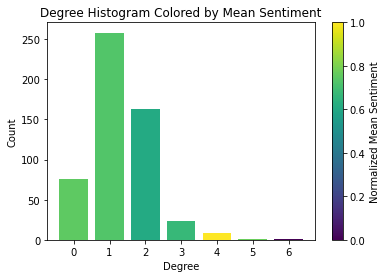

In [108]:
def plot_degreeSentiment(G):
    sentiments_by_degree = {}
    for node in G.nodes():
        degree = G.degree(node)
        sentiment = G.nodes[node]['sentiment']  # Assuming sentiment is stored in each node
        if degree not in sentiments_by_degree:
            sentiments_by_degree[degree] = []
        sentiments_by_degree[degree].append(sentiment)

    # Calculate mean sentiment for each degree
    mean_sentiments_by_degree = {degree: sum(sentiments) / len(sentiments) for degree, sentiments in sentiments_by_degree.items()}

    # Print or process the mean sentiments by degree
    for degree, mean_sentiment in mean_sentiments_by_degree.items():
        print(f"Degree {degree}: Mean Sentiment = {mean_sentiment}")

    # Normalize mean sentiment values to a 0-1 range for colormap
    min_sentiment = min(mean_sentiments_by_degree.values())
    max_sentiment = max(mean_sentiments_by_degree.values())
    normalized_sentiments = {degree: (sentiment - min_sentiment) / (max_sentiment - min_sentiment)
                            for degree, sentiment in mean_sentiments_by_degree.items()}

    # Create a colormap (choose a colormap that suits your preference)
    cmap = plt.cm.get_cmap('viridis')

    # Get the degree distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degree_count = dict((x, degree_sequence.count(x)) for x in set(degree_sequence))
    deg, cnt = zip(*degree_count.items())

    # Map the mean sentiment to colors
    colors = [cmap(normalized_sentiments[d]) if d in normalized_sentiments else cmap(0) for d in deg]

    # Plot the histogram with colored bars
    plt.bar(deg, cnt, width=0.80, color=colors)

    plt.title("Degree Histogram Colored by Mean Sentiment")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.xticks([d for d in deg])
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), label='Normalized Mean Sentiment')
    plt.show()


plot_degreeSentiment(G)

In [ ]:
atl_models[5].show_topic(topicid=2, time=9, topn=100)
# word cloud  for this

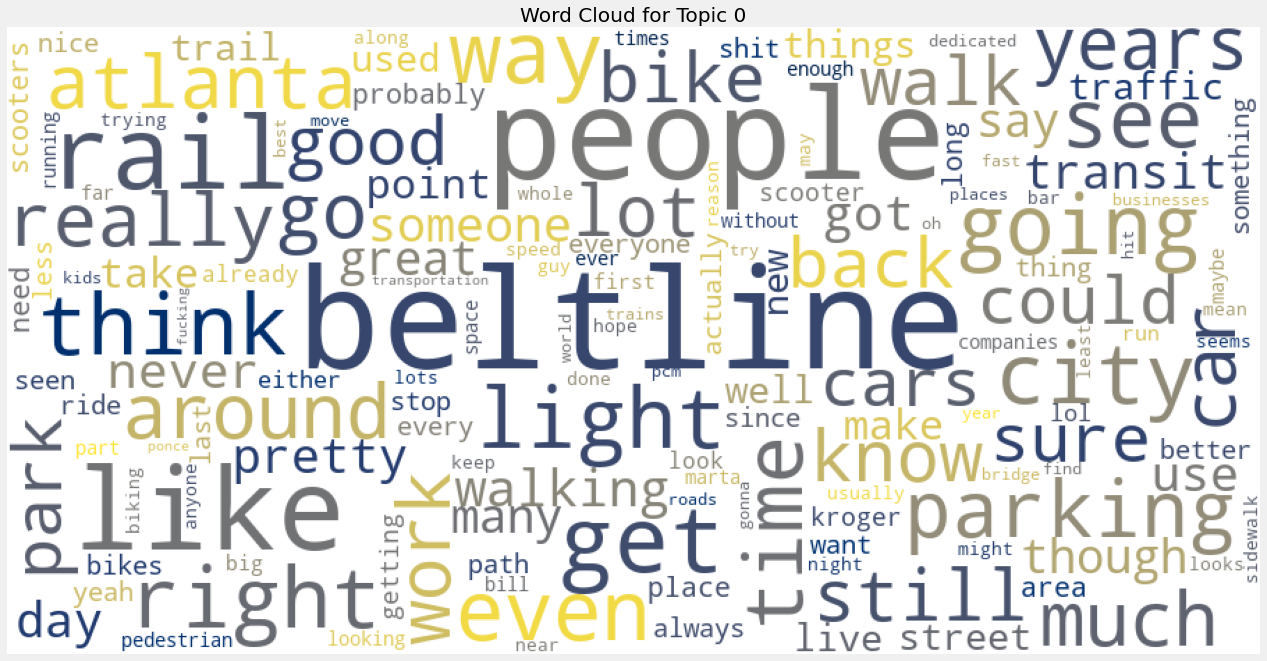

In [615]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topicid = 0
data_list = atl_models[5].show_topic(topicid=topicid, time=9, topn=150)
data_dict = {word: float(prob) for prob, word in data_list}

wordcloud = WordCloud(width=900, height=450,
                      max_font_size=100, max_words=200, background_color="white", colormap="cividis").generate_from_frequencies(data_dict)



plt.figure(figsize=(20, 16))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'Word Cloud for Topic {topicid}')
plt.show()

# avoid blurry wordclouds
# https://stackoverflow.com/questions/44661566/how-to-make-the-word-cloud-picture-clear



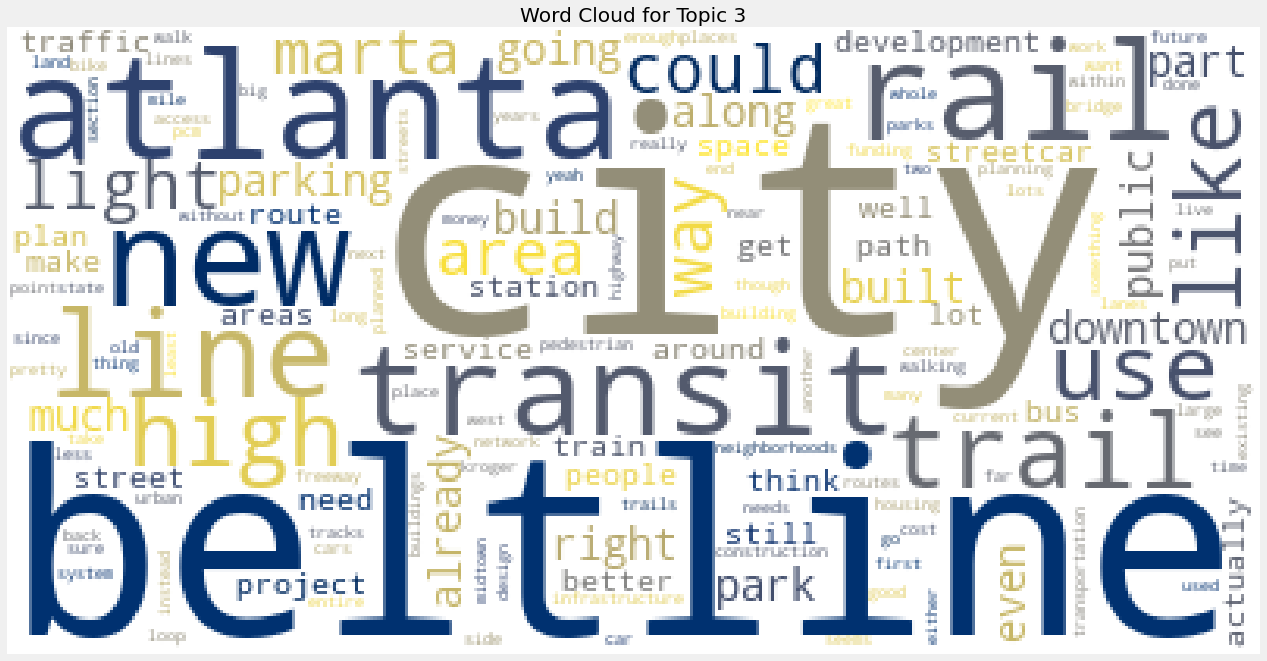

In [601]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
topicid = 3
data_list = meta_model.show_topic(topicid=topicid, time=9, topn=150)
data_dict = {word: float(prob) for prob, word in data_list}

wordcloud = WordCloud(max_font_size=100, max_words=200, background_color="white", colormap="cividis").generate_from_frequencies(data_dict)



plt.figure(figsize=(20, 16))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(f'Word Cloud for Topic {topicid}')
plt.show()


In [484]:
model = atl_models[5]

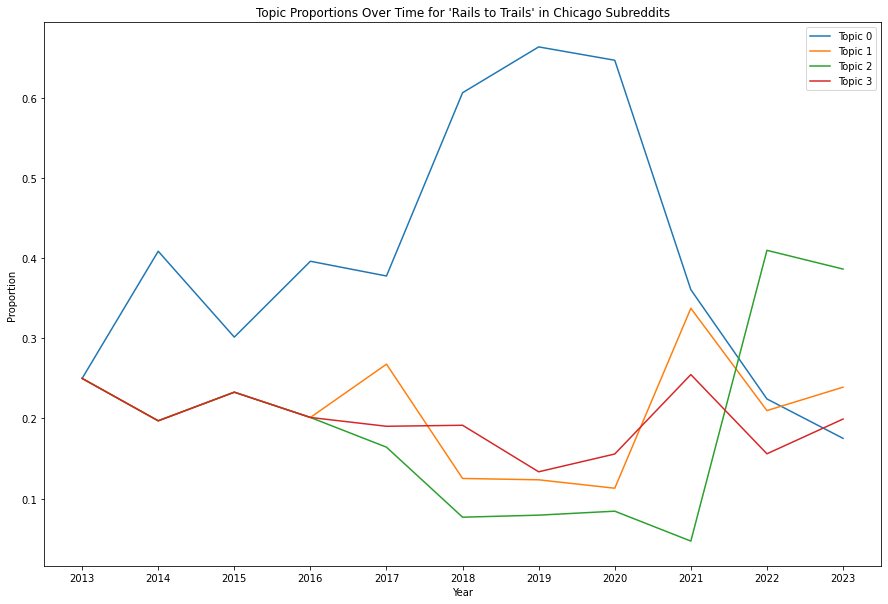

In [485]:

# Get the topic proportions for all documents
topic_proportions = model.gamma_ / np.sum(model.gamma_, axis=1, keepdims=True)

# Initialize a list to hold the topic sizes for each year
topic_sizes_per_year = []

# Initialize a counter for the current document
doc_counter = 0

# For each year, sum up the topic proportions
for year, num_docs in enumerate(timeslices):
    # Initialize a list to hold the topic sizes for this year
    topic_sizes = [0] * num_topics

    # Sum up the topic proportions for this year
    for _ in range(num_docs):
        doc_topics = topic_proportions[doc_counter]
        for topic, proportion in enumerate(doc_topics):
            topic_sizes[topic] += proportion
        doc_counter += 1

    # Add the topic sizes for this year to the list
    topic_sizes_per_year.append(topic_sizes)


# Convert the topic sizes to proportions
topic_proportions_per_year = topic_sizes_per_year / np.sum(topic_sizes_per_year, axis=1, keepdims=True)

plt.figure(figsize=(15, 10))
# Set the color map
plt.set_cmap('cividis')
# Create a line plot for each topic
for i in range(num_topics):
    plt.plot(range(len(topic_proportions_per_year)), topic_proportions_per_year[:, i], label='Topic {}'.format(i))


years = list(range(2013, 2024))  # replace with your actual years

# Set x-ticks
plt.xticks(range(len(years)), years)

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend()
plt.title("Topic Proportions Over Time for 'Rails to Trails' in Chicago Subreddits")

# Show the plot
plt.show()

In [474]:
atl_models[5].show_topic(topicid=3, time=9, topn=100)

[(0.05844119105740144, 'beltline'),
 (0.05466473569739699, 'trail'),
 (0.03604989343964853, 'https'),
 (0.03253518312243404, 'park'),
 (0.027235417154008876, 'com'),
 (0.022368441838793437, 'atlanta'),
 (0.01636261814418857, 'side'),
 (0.015391321472013799, 'www'),
 (0.01473342269511291, 'path'),
 (0.013233188863891888, 'bridge'),
 (0.012011439749579645, 'new'),
 (0.011717784793342617, 'section'),
 (0.011013992994848851, 'construction'),
 (0.010693106566128477, 'eastside'),
 (0.010413218048451856, 'along'),
 (0.009962736539912916, 'westside'),
 (0.00971516152284005, 'east'),
 (0.009557037299291658, 'already'),
 (0.009545588505566777, 'like'),
 (0.008838166731594021, 'going'),
 (0.008790884412933797, 'piedmont'),
 (0.008667952525596073, 'project'),
 (0.008034134682408548, 'southside'),
 (0.007908697701404743, 'part'),
 (0.007600298158174717, 'years'),
 (0.007593860115688191, 'area'),
 (0.007374843787818783, 'way'),
 (0.007253390654134072, 'trails'),
 (0.007020278600741335, 'first'),
 (0

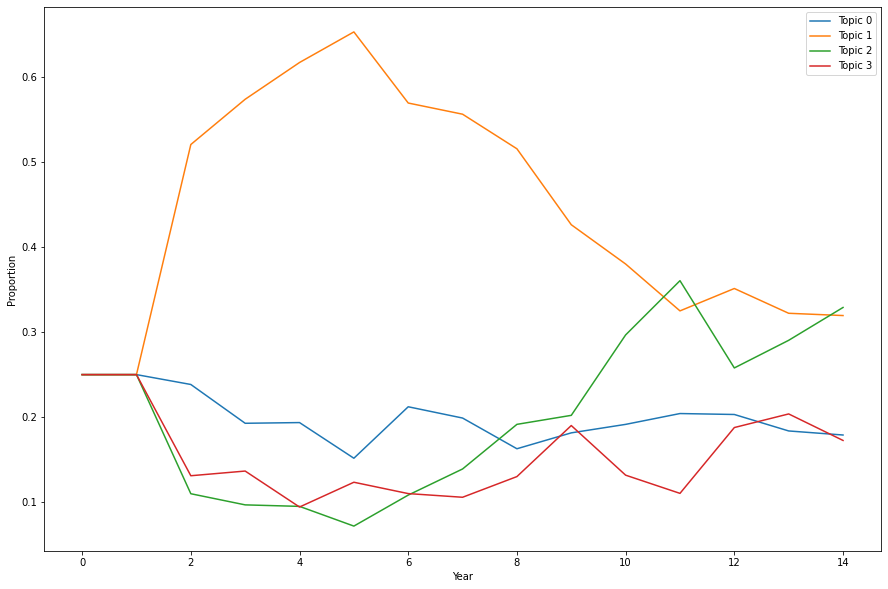

In [423]:
meta_model = plot_topic_proportions(meta_comments_df)

In [428]:
meta_model.show_topic(topicid=3, time=10, topn=100)

[(0.036084685580264245, 'beltline'),
 (0.030671172631195415, 'city'),
 (0.018432243797217144, 'atlanta'),
 (0.018302159031183207, 'transit'),
 (0.017209632038225647, 'rail'),
 (0.014672745754389887, 'new'),
 (0.013230840522066037, 'line'),
 (0.011846652754452274, 'trail'),
 (0.009325157300093935, 'use'),
 (0.008943949047062858, 'like'),
 (0.008240278224503494, 'way'),
 (0.008148340280944657, 'could'),
 (0.007623908926495465, 'light'),
 (0.0075991772969959985, 'marta'),
 (0.0074979748663711624, 'parking'),
 (0.007199175488195809, 'area'),
 (0.007006964079698056, 'much'),
 (0.006883093884155512, 'high'),
 (0.006647273994097553, 'already'),
 (0.006356099705110454, 'along'),
 (0.00633334668631757, 'park'),
 (0.0062481588503685405, 'right'),
 (0.006084179481688337, 'downtown'),
 (0.006010708230608893, 'built'),
 (0.006000909558582486, 'even'),
 (0.0057761627493714465, 'going'),
 (0.00570849589236683, 'public'),
 (0.005509890857208341, 'build'),
 (0.005483426842328759, 'project'),
 (0.005445

In [365]:
fltrd_users_df["comments_count"].describe()

count    5427.000000
mean        5.661692
std        61.579629
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      4484.000000
Name: comments_count, dtype: float64

In [447]:
indepth_df = []

for idx, row in meta_comments_df.iterrows():
    user = row['author']
    text = row['body']
    # convert row to list
    row = row.tolist()

    if user == "killroy200":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)

    elif user == "Miser":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)


    elif user == "ArchEast":
        sentiment = get_sentiment(text)
        row.append(sentiment)
        indepth_df.append(row)


indepth_df = pd.DataFrame(indepth_df)
indepth_df.columns = ["comment_id","parent_id","body","author","time","score","subreddit_id","thread_id","year","subreddit_name","sentiment","bert","senti"]


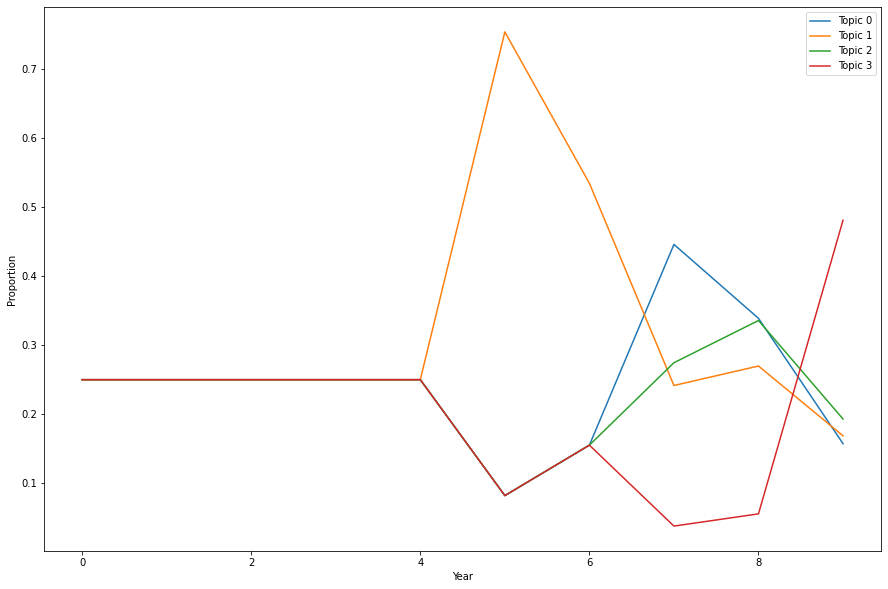

In [448]:
model = plot_topic_proportions(indepth_df)

In [453]:
model.show_topic(topicid=3, time=9, topn=100)

[(0.06175160639482629, 'people'),
 (0.060913594044230586, 'city'),
 (0.05640891265408597, 'even'),
 (0.051435203203808864, 'parking'),
 (0.04425251828076413, 'housing'),
 (0.03375099117093492, 'like'),
 (0.03189546355584927, 'park'),
 (0.031536780069013774, 'want'),
 (0.03059204913203206, 'need'),
 (0.02830493695410986, 'built'),
 (0.0281785445817948, 'still'),
 (0.02806067628172667, 'car'),
 (0.026302621571713588, 'beltline'),
 (0.025122912955520552, 'atlanta'),
 (0.024906046137978515, 'things'),
 (0.024532696158956008, 'development'),
 (0.022985687874016524, 'much'),
 (0.02278796637416926, 'new'),
 (0.02277483948901064, 'enough'),
 (0.022453984652214046, 'many'),
 (0.021842161786326336, 'use'),
 (0.02128324345814107, 'cars'),
 (0.019945834825396597, 'time'),
 (0.01985772751785559, 'already'),
 (0.01902171005045237, 'work'),
 (0.01892696717542726, 'around'),
 (0.016860360611486606, 'get'),
 (0.015960348399720728, 'well'),
 (0.015308696553985398, 'way'),
 (0.014014159240618062, 'going'

## Trying Graphviz

### Didn't work

In [27]:
from graphviz import Digraph

# Assuming comments_df is your DataFrame with 'comment_id' and 'parent_id'

# Initialize a directed graph
dot = Digraph(comment='Reddit Comments')

# Add nodes and edges
for index, row in test_df.iterrows():
    # Add current comment as a node
    dot.node(row['comment_id'], row['comment_id'])

    # Add an edge from parent to current comment, if parent_id exists
    if pd.notna(row['parent_id']) and row['parent_id'] in test_df['comment_id'].values:
        dot.edge(row['parent_id'], row['comment_id'])

# Render and view the graph
dot.render('reddit_comments_tree', view=True, format='png')


'reddit_comments_tree.png'

In [93]:
# useless
new_users_df = meta_comments_df.groupby("author").describe()

In [469]:
meta_comments_df.to_html("meta_comments_df.html")